## 전처리한 데이터 가지고 오기

In [1]:
%pip install -q lightgbm scikit-learn optuna

Note: you may need to restart the kernel to use updated packages.


In [29]:
# ライブラリのインポート
import pandas as pd
import lightgbm as lgb
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import early_stopping, log_evaluation

In [30]:
# データ読み込み
df = pd.read_csv('../data/combined_batches_cleaned_26k_3.csv')

In [31]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78000 entries, 0 to 77999
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   url                   78000 non-null  object 
 1   url_type              78000 non-null  int64  
 2   url_len               78000 non-null  int64  
 3   letters_count         78000 non-null  int64  
 4   digits_count          78000 non-null  int64  
 5   special_chars_count   78000 non-null  int64  
 6   shortened             78000 non-null  int64  
 7   is_domain_in_url      78000 non-null  int64  
 8   secure_http           78000 non-null  int64  
 9   redirect_count        78000 non-null  int64  
 10  duration_sec          78000 non-null  float64
 11  meta_count            78000 non-null  float64
 12  link_count            78000 non-null  float64
 13  title_count           78000 non-null  float64
 14  has_title             78000 non-null  bool   
 15  has_meta_descriptio

,url,url_type,url_len,letters_count,digits_count,special_chars_count,shortened,is_domain_in_url,secure_http,redirect_count,...,has_og_image,has_og_title,has_link_stylesheet,performance_score,FCP,LCP,CLS,TTFB,SpeedIndex,TBT
0,123people.com/c/george+beers,0,28,21,3,4,0,0,0,1,...,False,True,True,0.98,522.000000,642.000000,0.033901,944.0,1374.654466,0.0
1,biographi.ca/009004-119.01-e.php?&id_nbr=8097,0,45,20,15,10,0,0,0,4,...,True,True,True,0.94,822.038853,1046.341351,0.034177,199.0,1866.525789,25.5
2,http://xhamster.com/movies/1515821/bisexual_cu...,0,94,77,7,17,0,1,0,2,...,True,True,True,0.50,1512.414532,5089.235989,0.012295,700.0,2208.209373,399.0
3,nannu.info/music/artists/shreya-ghoshal/,0,40,34,0,6,0,0,0,1,...,False,False,False,0.78,906.283111,1703.476934,0.071229,116.0,2767.985784,214.0
4,en.wikipedia.org/wiki/Walloons,0,30,26,0,4,0,0,0,1,...,True,True,True,0.96,504.000000,1032.000000,0.000892,355.0,1758.528203,11.5


特徴量とラベルに分割

In [32]:
# 特徴量とラベルの分離
y = df['url_type']  # ← 例：0=benign, 1=phishing, 2=malwareなど
X = df.drop(columns=['url_type', 'url_len', 'letters_count','performance_score','title_count'])
X = X.select_dtypes(include=['int64', 'float64', 'bool'])

学習・検証データに分割

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

LightGBMデータ形式に変換

In [34]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

### Optunaによるハイパーパラメータチューニング

In [39]:
def objective(trial):
    param = {
        'objective': 'multiclass',
        'num_class': y.nunique(),
        'metric': 'multi_logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'verbosity': -1,
        'feature_pre_filter': False
    }

    # ここで Dataset を都度作成することで pre_filter 問題を回避
    train_dataset = lgb.Dataset(X_train, label=y_train)
    valid_dataset = lgb.Dataset(X_test, label=y_test)

    model = lgb.train(
        param,
        train_dataset,
        valid_sets=[valid_dataset],
        num_boost_round=100,
        callbacks=[
            early_stopping(stopping_rounds=10),
            log_evaluation(period=0)
        ]
    )

    preds = model.predict(X_test)
    pred_labels = preds.argmax(axis=1)
    accuracy = (pred_labels == y_test).mean()
    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print("🔧 Best parameters found by Optuna:")
print(study.best_params)

[I 2025-06-09 11:15:53,438] A new study created in memory with name: no-name-48cbb8f7-5912-4663-8424-dd9876cc6c8f


Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:15:54,778] Trial 0 finished with value: 0.8738461538461538 and parameters: {'learning_rate': 0.23677005018589337, 'num_leaves': 115, 'max_depth': 7, 'min_data_in_leaf': 48, 'feature_fraction': 0.6212056883185234, 'bagging_fraction': 0.6232582528793974, 'bagging_freq': 1}. Best is trial 0 with value: 0.8738461538461538.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.291142
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:15:55,514] Trial 1 finished with value: 0.8402564102564103 and parameters: {'learning_rate': 0.13456570718796895, 'num_leaves': 73, 'max_depth': 4, 'min_data_in_leaf': 86, 'feature_fraction': 0.6387019832711962, 'bagging_fraction': 0.8894238295657864, 'bagging_freq': 5}. Best is trial 0 with value: 0.8738461538461538.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.376388
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:15:56,310] Trial 2 finished with value: 0.862948717948718 and parameters: {'learning_rate': 0.21770328583471318, 'num_leaves': 133, 'max_depth': 5, 'min_data_in_leaf': 70, 'feature_fraction': 0.9438009232898492, 'bagging_fraction': 0.856621837946262, 'bagging_freq': 5}. Best is trial 0 with value: 0.8738461538461538.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.323148
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:15:57,599] Trial 3 finished with value: 0.8796794871794872 and parameters: {'learning_rate': 0.2046990521526727, 'num_leaves': 58, 'max_depth': 10, 'min_data_in_leaf': 48, 'feature_fraction': 0.9213073754518197, 'bagging_fraction': 0.8862113189429102, 'bagging_freq': 7}. Best is trial 3 with value: 0.8796794871794872.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.280983
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:15:58,645] Trial 4 finished with value: 0.8741666666666666 and parameters: {'learning_rate': 0.23931395886914433, 'num_leaves': 38, 'max_depth': 14, 'min_data_in_leaf': 50, 'feature_fraction': 0.8649340781750743, 'bagging_fraction': 0.7099602696045968, 'bagging_freq': 7}. Best is trial 3 with value: 0.8796794871794872.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.290388
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:01,033] Trial 5 finished with value: 0.8642948717948717 and parameters: {'learning_rate': 0.042556929580179, 'num_leaves': 125, 'max_depth': 13, 'min_data_in_leaf': 98, 'feature_fraction': 0.8196842047100033, 'bagging_fraction': 0.6859476983838453, 'bagging_freq': 2}. Best is trial 3 with value: 0.8796794871794872.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.327799
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:01,565] Trial 6 finished with value: 0.8351923076923077 and parameters: {'learning_rate': 0.2139982781772717, 'num_leaves': 98, 'max_depth': 3, 'min_data_in_leaf': 19, 'feature_fraction': 0.6764827206121324, 'bagging_fraction': 0.6049188109929415, 'bagging_freq': 2}. Best is trial 3 with value: 0.8796794871794872.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.385189
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:03,098] Trial 7 finished with value: 0.867051282051282 and parameters: {'learning_rate': 0.07788247244533054, 'num_leaves': 56, 'max_depth': 15, 'min_data_in_leaf': 43, 'feature_fraction': 0.6679353847724689, 'bagging_fraction': 0.6852092410151122, 'bagging_freq': 4}. Best is trial 3 with value: 0.8796794871794872.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.312685
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:05,583] Trial 8 finished with value: 0.8687179487179487 and parameters: {'learning_rate': 0.049319910748515106, 'num_leaves': 120, 'max_depth': 14, 'min_data_in_leaf': 99, 'feature_fraction': 0.8300166489841148, 'bagging_fraction': 0.9464623642431411, 'bagging_freq': 4}. Best is trial 3 with value: 0.8796794871794872.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.312672
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:06,680] Trial 9 finished with value: 0.8781410256410257 and parameters: {'learning_rate': 0.2515952837288321, 'num_leaves': 41, 'max_depth': 12, 'min_data_in_leaf': 74, 'feature_fraction': 0.9175779212102093, 'bagging_fraction': 0.7403626845115459, 'bagging_freq': 5}. Best is trial 3 with value: 0.8796794871794872.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.286083
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:07,522] Trial 10 finished with value: 0.8638461538461538 and parameters: {'learning_rate': 0.15634360752251458, 'num_leaves': 25, 'max_depth': 10, 'min_data_in_leaf': 24, 'feature_fraction': 0.9845875747182979, 'bagging_fraction': 0.9999995527466338, 'bagging_freq': 7}. Best is trial 3 with value: 0.8796794871794872.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.31765
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:08,912] Trial 11 finished with value: 0.8809615384615385 and parameters: {'learning_rate': 0.2909001777563533, 'num_leaves': 61, 'max_depth': 11, 'min_data_in_leaf': 69, 'feature_fraction': 0.9035810600195817, 'bagging_fraction': 0.7912880050000825, 'bagging_freq': 6}. Best is trial 11 with value: 0.8809615384615385.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.277569
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:10,538] Trial 12 finished with value: 0.8801923076923077 and parameters: {'learning_rate': 0.28718605913411505, 'num_leaves': 77, 'max_depth': 10, 'min_data_in_leaf': 65, 'feature_fraction': 0.7326927601195573, 'bagging_fraction': 0.8038551560736421, 'bagging_freq': 7}. Best is trial 11 with value: 0.8809615384615385.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.277518
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:11,845] Trial 13 finished with value: 0.8790384615384615 and parameters: {'learning_rate': 0.2939646029179255, 'num_leaves': 95, 'max_depth': 7, 'min_data_in_leaf': 66, 'feature_fraction': 0.7378249939865104, 'bagging_fraction': 0.7927404545686627, 'bagging_freq': 6}. Best is trial 11 with value: 0.8809615384615385.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.284485
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:13,340] Trial 14 finished with value: 0.883525641025641 and parameters: {'learning_rate': 0.29952568262625134, 'num_leaves': 73, 'max_depth': 11, 'min_data_in_leaf': 61, 'feature_fraction': 0.7423666384427358, 'bagging_fraction': 0.800214090823463, 'bagging_freq': 6}. Best is trial 14 with value: 0.883525641025641.


Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.276361
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:14,773] Trial 15 finished with value: 0.884423076923077 and parameters: {'learning_rate': 0.29617757439429077, 'num_leaves': 60, 'max_depth': 12, 'min_data_in_leaf': 79, 'feature_fraction': 0.7631962381373308, 'bagging_fraction': 0.7928890201873827, 'bagging_freq': 6}. Best is trial 15 with value: 0.884423076923077.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.273716
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:16,371] Trial 16 finished with value: 0.8751282051282051 and parameters: {'learning_rate': 0.16854789728912117, 'num_leaves': 91, 'max_depth': 8, 'min_data_in_leaf': 84, 'feature_fraction': 0.7611994461648889, 'bagging_fraction': 0.8398612997081178, 'bagging_freq': 4}. Best is trial 15 with value: 0.884423076923077.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.29001
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:17,954] Trial 17 finished with value: 0.8830128205128205 and parameters: {'learning_rate': 0.2543224585451858, 'num_leaves': 73, 'max_depth': 12, 'min_data_in_leaf': 33, 'feature_fraction': 0.7743164649878358, 'bagging_fraction': 0.762759614262183, 'bagging_freq': 6}. Best is trial 15 with value: 0.884423076923077.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.275648
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:19,171] Trial 18 finished with value: 0.8660897435897436 and parameters: {'learning_rate': 0.10735021771529069, 'num_leaves': 43, 'max_depth': 9, 'min_data_in_leaf': 58, 'feature_fraction': 0.7048616238105184, 'bagging_fraction': 0.8330084693292178, 'bagging_freq': 3}. Best is trial 15 with value: 0.884423076923077.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.312119
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:21,450] Trial 19 finished with value: 0.8456410256410256 and parameters: {'learning_rate': 0.013009621495064239, 'num_leaves': 106, 'max_depth': 12, 'min_data_in_leaf': 81, 'feature_fraction': 0.8034774899191834, 'bagging_fraction': 0.9083688365974342, 'bagging_freq': 6}. Best is trial 15 with value: 0.884423076923077.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.503074
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:23,119] Trial 20 finished with value: 0.8814102564102564 and parameters: {'learning_rate': 0.17928089747949372, 'num_leaves': 83, 'max_depth': 15, 'min_data_in_leaf': 37, 'feature_fraction': 0.8588007411614113, 'bagging_fraction': 0.7435672888611863, 'bagging_freq': 5}. Best is trial 15 with value: 0.884423076923077.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.2751
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:24,645] Trial 21 finished with value: 0.8823076923076923 and parameters: {'learning_rate': 0.26501211252634865, 'num_leaves': 73, 'max_depth': 12, 'min_data_in_leaf': 30, 'feature_fraction': 0.7744482030766926, 'bagging_fraction': 0.7572524338045107, 'bagging_freq': 6}. Best is trial 15 with value: 0.884423076923077.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.275944
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:26,078] Trial 22 finished with value: 0.8796794871794872 and parameters: {'learning_rate': 0.2746044228200023, 'num_leaves': 65, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7765540174990484, 'bagging_fraction': 0.7754795640861184, 'bagging_freq': 6}. Best is trial 15 with value: 0.884423076923077.


Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.281613
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:27,797] Trial 23 finished with value: 0.8809615384615385 and parameters: {'learning_rate': 0.2974889877311717, 'num_leaves': 149, 'max_depth': 11, 'min_data_in_leaf': 58, 'feature_fraction': 0.7198428777664454, 'bagging_fraction': 0.7204904547266628, 'bagging_freq': 5}. Best is trial 15 with value: 0.884423076923077.


Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.278585
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:29,053] Trial 24 finished with value: 0.8798717948717949 and parameters: {'learning_rate': 0.2617447917924595, 'num_leaves': 48, 'max_depth': 11, 'min_data_in_leaf': 37, 'feature_fraction': 0.6794570111144588, 'bagging_fraction': 0.8200200636123457, 'bagging_freq': 6}. Best is trial 15 with value: 0.884423076923077.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.280281
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:30,073] Trial 25 finished with value: 0.8706410256410256 and parameters: {'learning_rate': 0.23996108174992462, 'num_leaves': 30, 'max_depth': 13, 'min_data_in_leaf': 90, 'feature_fraction': 0.755490461712771, 'bagging_fraction': 0.6405932985906543, 'bagging_freq': 7}. Best is trial 15 with value: 0.884423076923077.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.298556
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:31,728] Trial 26 finished with value: 0.8789102564102564 and parameters: {'learning_rate': 0.18942450792284163, 'num_leaves': 84, 'max_depth': 9, 'min_data_in_leaf': 76, 'feature_fraction': 0.8386176366021836, 'bagging_fraction': 0.7659235513956798, 'bagging_freq': 3}. Best is trial 15 with value: 0.884423076923077.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.282335
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:33,229] Trial 27 finished with value: 0.8851923076923077 and parameters: {'learning_rate': 0.2679375743700305, 'num_leaves': 67, 'max_depth': 14, 'min_data_in_leaf': 55, 'feature_fraction': 0.7950521219824006, 'bagging_fraction': 0.8613700510535182, 'bagging_freq': 5}. Best is trial 27 with value: 0.8851923076923077.


Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.272646
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:34,592] Trial 28 finished with value: 0.8821153846153846 and parameters: {'learning_rate': 0.2738425167720502, 'num_leaves': 52, 'max_depth': 14, 'min_data_in_leaf': 58, 'feature_fraction': 0.8001566297816005, 'bagging_fraction': 0.864215529561824, 'bagging_freq': 5}. Best is trial 27 with value: 0.8851923076923077.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.276522
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:36,094] Trial 29 finished with value: 0.8858333333333334 and parameters: {'learning_rate': 0.23078498875069797, 'num_leaves': 65, 'max_depth': 15, 'min_data_in_leaf': 61, 'feature_fraction': 0.6196419240309987, 'bagging_fraction': 0.943315195891931, 'bagging_freq': 1}. Best is trial 29 with value: 0.8858333333333334.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.27223
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:37,517] Trial 30 finished with value: 0.8833333333333333 and parameters: {'learning_rate': 0.22592114601412863, 'num_leaves': 65, 'max_depth': 15, 'min_data_in_leaf': 51, 'feature_fraction': 0.6063076506360588, 'bagging_fraction': 0.9470788265918227, 'bagging_freq': 1}. Best is trial 29 with value: 0.8858333333333334.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.274478
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:38,970] Trial 31 finished with value: 0.8846153846153846 and parameters: {'learning_rate': 0.2780310171285174, 'num_leaves': 67, 'max_depth': 14, 'min_data_in_leaf': 63, 'feature_fraction': 0.628624341372941, 'bagging_fraction': 0.9343000658639932, 'bagging_freq': 1}. Best is trial 29 with value: 0.8858333333333334.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.27306
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:40,407] Trial 32 finished with value: 0.8838461538461538 and parameters: {'learning_rate': 0.23403345827591382, 'num_leaves': 66, 'max_depth': 14, 'min_data_in_leaf': 76, 'feature_fraction': 0.6394926885611361, 'bagging_fraction': 0.9321653238400387, 'bagging_freq': 1}. Best is trial 29 with value: 0.8858333333333334.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.274756
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:41,775] Trial 33 finished with value: 0.881474358974359 and parameters: {'learning_rate': 0.2744753693109437, 'num_leaves': 49, 'max_depth': 15, 'min_data_in_leaf': 44, 'feature_fraction': 0.6332781895812775, 'bagging_fraction': 0.9899166281696536, 'bagging_freq': 2}. Best is trial 29 with value: 0.8858333333333334.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.280176
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:43,399] Trial 34 finished with value: 0.8827564102564103 and parameters: {'learning_rate': 0.1982137231785709, 'num_leaves': 79, 'max_depth': 13, 'min_data_in_leaf': 53, 'feature_fraction': 0.6057378929619728, 'bagging_fraction': 0.9674483813117721, 'bagging_freq': 1}. Best is trial 29 with value: 0.8858333333333334.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.274533
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:44,536] Trial 35 finished with value: 0.8748717948717949 and parameters: {'learning_rate': 0.24392412615478376, 'num_leaves': 34, 'max_depth': 14, 'min_data_in_leaf': 63, 'feature_fraction': 0.657081195685269, 'bagging_fraction': 0.8992931464046314, 'bagging_freq': 3}. Best is trial 29 with value: 0.8858333333333334.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.291551
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:46,147] Trial 36 finished with value: 0.8830769230769231 and parameters: {'learning_rate': 0.2178515376558349, 'num_leaves': 68, 'max_depth': 15, 'min_data_in_leaf': 71, 'feature_fraction': 0.6961039322571276, 'bagging_fraction': 0.87095993217901, 'bagging_freq': 2}. Best is trial 29 with value: 0.8858333333333334.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.273088
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:47,523] Trial 37 finished with value: 0.8760897435897436 and parameters: {'learning_rate': 0.14100919223476763, 'num_leaves': 58, 'max_depth': 13, 'min_data_in_leaf': 93, 'feature_fraction': 0.882060536153996, 'bagging_fraction': 0.9225165653012177, 'bagging_freq': 1}. Best is trial 29 with value: 0.8858333333333334.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.287205
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:49,161] Trial 38 finished with value: 0.8833974358974359 and parameters: {'learning_rate': 0.2738302045696595, 'num_leaves': 104, 'max_depth': 14, 'min_data_in_leaf': 47, 'feature_fraction': 0.6397610339987383, 'bagging_fraction': 0.8887843157657204, 'bagging_freq': 2}. Best is trial 29 with value: 0.8858333333333334.


Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.271403
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:50,932] Trial 39 finished with value: 0.885 and parameters: {'learning_rate': 0.20538589289008383, 'num_leaves': 87, 'max_depth': 13, 'min_data_in_leaf': 82, 'feature_fraction': 0.7028660673624786, 'bagging_fraction': 0.9718633609329912, 'bagging_freq': 1}. Best is trial 29 with value: 0.8858333333333334.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.270604
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:52,681] Trial 40 finished with value: 0.8832692307692308 and parameters: {'learning_rate': 0.21073984330267337, 'num_leaves': 89, 'max_depth': 14, 'min_data_in_leaf': 90, 'feature_fraction': 0.6581013516597162, 'bagging_fraction': 0.974355780368436, 'bagging_freq': 1}. Best is trial 29 with value: 0.8858333333333334.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.269598
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:53,489] Trial 41 finished with value: 0.8630128205128205 and parameters: {'learning_rate': 0.22933665326436742, 'num_leaves': 56, 'max_depth': 5, 'min_data_in_leaf': 79, 'feature_fraction': 0.7030023858343344, 'bagging_fraction': 0.9618113916546404, 'bagging_freq': 1}. Best is trial 29 with value: 0.8858333333333334.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.323088
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:55,229] Trial 42 finished with value: 0.883525641025641 and parameters: {'learning_rate': 0.25254339088223166, 'num_leaves': 78, 'max_depth': 13, 'min_data_in_leaf': 71, 'feature_fraction': 0.6256492066467092, 'bagging_fraction': 0.9161763813509752, 'bagging_freq': 2}. Best is trial 29 with value: 0.8858333333333334.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.274426
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:57,191] Trial 43 finished with value: 0.8866025641025641 and parameters: {'learning_rate': 0.2817703696619771, 'num_leaves': 102, 'max_depth': 15, 'min_data_in_leaf': 84, 'feature_fraction': 0.6850206090082719, 'bagging_fraction': 0.9404042516949994, 'bagging_freq': 1}. Best is trial 43 with value: 0.8866025641025641.


Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.273178
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:16:59,070] Trial 44 finished with value: 0.8861538461538462 and parameters: {'learning_rate': 0.28012533474435813, 'num_leaves': 106, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.6712764569496341, 'bagging_fraction': 0.9483795855128985, 'bagging_freq': 1}. Best is trial 43 with value: 0.8866025641025641.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.268876
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:01,258] Trial 45 finished with value: 0.8892307692307693 and parameters: {'learning_rate': 0.2589868935300565, 'num_leaves': 115, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.6772199110573924, 'bagging_fraction': 0.9820503168350059, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.265445
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:03,492] Trial 46 finished with value: 0.886474358974359 and parameters: {'learning_rate': 0.25803537660885034, 'num_leaves': 114, 'max_depth': 15, 'min_data_in_leaf': 97, 'feature_fraction': 0.6840895321999444, 'bagging_fraction': 0.9873595569976551, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.269423
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:05,766] Trial 47 finished with value: 0.884102564102564 and parameters: {'learning_rate': 0.2500581314675664, 'num_leaves': 126, 'max_depth': 15, 'min_data_in_leaf': 96, 'feature_fraction': 0.6678070510767611, 'bagging_fraction': 0.9998630930764904, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.271249
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:07,995] Trial 48 finished with value: 0.8853846153846154 and parameters: {'learning_rate': 0.2835442691586849, 'num_leaves': 113, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.6878698194588962, 'bagging_fraction': 0.9836424432686945, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.271188
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:09,847] Trial 49 finished with value: 0.8837820512820512 and parameters: {'learning_rate': 0.2614334054561003, 'num_leaves': 113, 'max_depth': 15, 'min_data_in_leaf': 95, 'feature_fraction': 0.726311147714359, 'bagging_fraction': 0.9458662881822113, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.270747
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:12,014] Trial 50 finished with value: 0.8841666666666667 and parameters: {'learning_rate': 0.28684336742637856, 'num_leaves': 102, 'max_depth': 15, 'min_data_in_leaf': 100, 'feature_fraction': 0.6504501940203102, 'bagging_fraction': 0.9576971833968766, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.271862
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:14,375] Trial 51 finished with value: 0.8858333333333334 and parameters: {'learning_rate': 0.2881583948472036, 'num_leaves': 113, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.6736909168327591, 'bagging_fraction': 0.9808722471361837, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.273682
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:16,707] Trial 52 finished with value: 0.8885897435897436 and parameters: {'learning_rate': 0.25860822340573325, 'num_leaves': 119, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.6747922929722172, 'bagging_fraction': 0.985799912043994, 'bagging_freq': 3}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.268014
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:19,206] Trial 53 finished with value: 0.8857051282051283 and parameters: {'learning_rate': 0.22359680354582223, 'num_leaves': 132, 'max_depth': 14, 'min_data_in_leaf': 91, 'feature_fraction': 0.6027892400907308, 'bagging_fraction': 0.9548891624930684, 'bagging_freq': 3}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.266865
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:21,367] Trial 54 finished with value: 0.8863461538461539 and parameters: {'learning_rate': 0.24503218049052525, 'num_leaves': 122, 'max_depth': 15, 'min_data_in_leaf': 85, 'feature_fraction': 0.7172702998256103, 'bagging_fraction': 0.9353249612911897, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.270819
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:22,507] Trial 55 finished with value: 0.8693589743589744 and parameters: {'learning_rate': 0.24655083321874266, 'num_leaves': 120, 'max_depth': 6, 'min_data_in_leaf': 86, 'feature_fraction': 0.6853635470156122, 'bagging_fraction': 0.9973784269895645, 'bagging_freq': 3}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.302547
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:24,958] Trial 56 finished with value: 0.8825641025641026 and parameters: {'learning_rate': 0.09935270930262863, 'num_leaves': 138, 'max_depth': 14, 'min_data_in_leaf': 96, 'feature_fraction': 0.7161129075896269, 'bagging_fraction': 0.9336566839935049, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.27886
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:27,071] Trial 57 finished with value: 0.8855128205128205 and parameters: {'learning_rate': 0.2590457570574568, 'num_leaves': 119, 'max_depth': 15, 'min_data_in_leaf': 83, 'feature_fraction': 0.7445651350943074, 'bagging_fraction': 0.9027543163926912, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.270372
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:29,268] Trial 58 finished with value: 0.8835897435897436 and parameters: {'learning_rate': 0.29897023505341097, 'num_leaves': 109, 'max_depth': 14, 'min_data_in_leaf': 79, 'feature_fraction': 0.7165250934520261, 'bagging_fraction': 0.9711683827814288, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.27226
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:29,870] Trial 59 finished with value: 0.8375 and parameters: {'learning_rate': 0.23853224657764652, 'num_leaves': 96, 'max_depth': 3, 'min_data_in_leaf': 92, 'feature_fraction': 0.9637081434752601, 'bagging_fraction': 0.8785979150796148, 'bagging_freq': 3}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.379637
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:31,992] Trial 60 finished with value: 0.8861538461538462 and parameters: {'learning_rate': 0.26582415989883945, 'num_leaves': 129, 'max_depth': 13, 'min_data_in_leaf': 88, 'feature_fraction': 0.6641768640759864, 'bagging_fraction': 0.9190085405578063, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.268848
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:34,078] Trial 61 finished with value: 0.8838461538461538 and parameters: {'learning_rate': 0.26706526632158045, 'num_leaves': 128, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.6654654264985991, 'bagging_fraction': 0.9236540241807736, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.270409
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:36,137] Trial 62 finished with value: 0.8880128205128205 and parameters: {'learning_rate': 0.28235381556454725, 'num_leaves': 119, 'max_depth': 15, 'min_data_in_leaf': 89, 'feature_fraction': 0.6894199226390002, 'bagging_fraction': 0.9812248196187657, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.268601
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:38,521] Trial 63 finished with value: 0.8875641025641026 and parameters: {'learning_rate': 0.25277856935210286, 'num_leaves': 139, 'max_depth': 15, 'min_data_in_leaf': 98, 'feature_fraction': 0.6924192010591789, 'bagging_fraction': 0.9845935873399734, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267559
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:41,012] Trial 64 finished with value: 0.8876923076923077 and parameters: {'learning_rate': 0.25288705412130086, 'num_leaves': 140, 'max_depth': 15, 'min_data_in_leaf': 98, 'feature_fraction': 0.6944981418764247, 'bagging_fraction': 0.9852765740374799, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.268486
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:43,508] Trial 65 finished with value: 0.8859615384615385 and parameters: {'learning_rate': 0.25719457063471246, 'num_leaves': 144, 'max_depth': 14, 'min_data_in_leaf': 98, 'feature_fraction': 0.6886562497288824, 'bagging_fraction': 0.9829935888235549, 'bagging_freq': 4}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.26954
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:46,037] Trial 66 finished with value: 0.886474358974359 and parameters: {'learning_rate': 0.2899024850611073, 'num_leaves': 144, 'max_depth': 14, 'min_data_in_leaf': 95, 'feature_fraction': 0.644492261011747, 'bagging_fraction': 0.9876186376254004, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.266935
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:47,708] Trial 67 finished with value: 0.88 and parameters: {'learning_rate': 0.2528729363093216, 'num_leaves': 137, 'max_depth': 8, 'min_data_in_leaf': 100, 'feature_fraction': 0.6989765380784586, 'bagging_fraction': 0.9637242844876738, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.281693
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:50,164] Trial 68 finished with value: 0.8848076923076923 and parameters: {'learning_rate': 0.22019524787270234, 'num_leaves': 136, 'max_depth': 14, 'min_data_in_leaf': 93, 'feature_fraction': 0.7452635355962859, 'bagging_fraction': 0.9940273648669897, 'bagging_freq': 4}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.268134
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:52,414] Trial 69 finished with value: 0.8852564102564102 and parameters: {'learning_rate': 0.23641898776535977, 'num_leaves': 117, 'max_depth': 15, 'min_data_in_leaf': 98, 'feature_fraction': 0.6808833829455785, 'bagging_fraction': 0.9749325795658889, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.268277
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:54,250] Trial 70 finished with value: 0.8657692307692307 and parameters: {'learning_rate': 0.04538564341521975, 'num_leaves': 99, 'max_depth': 13, 'min_data_in_leaf': 89, 'feature_fraction': 0.7355097514553142, 'bagging_fraction': 0.9577801435499775, 'bagging_freq': 3}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.326156
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:56,114] Trial 71 finished with value: 0.8833974358974359 and parameters: {'learning_rate': 0.288750889136648, 'num_leaves': 144, 'max_depth': 15, 'min_data_in_leaf': 94, 'feature_fraction': 0.6575118103349887, 'bagging_fraction': 0.9871145757096891, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.271563
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:17:58,691] Trial 72 finished with value: 0.8890384615384616 and parameters: {'learning_rate': 0.27069601969704304, 'num_leaves': 143, 'max_depth': 14, 'min_data_in_leaf': 97, 'feature_fraction': 0.6513850999720351, 'bagging_fraction': 0.9849188708341104, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.266687
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:02,073] Trial 73 finished with value: 0.8886538461538461 and parameters: {'learning_rate': 0.2766826391843592, 'num_leaves': 150, 'max_depth': 15, 'min_data_in_leaf': 98, 'feature_fraction': 0.691346984959337, 'bagging_fraction': 0.9776942780399879, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.267991
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:04,589] Trial 74 finished with value: 0.886474358974359 and parameters: {'learning_rate': 0.2720687816055524, 'num_leaves': 150, 'max_depth': 14, 'min_data_in_leaf': 91, 'feature_fraction': 0.7097356233735224, 'bagging_fraction': 0.9710424335574296, 'bagging_freq': 3}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.269902
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:06,542] Trial 75 finished with value: 0.8864102564102564 and parameters: {'learning_rate': 0.26829592966300264, 'num_leaves': 141, 'max_depth': 15, 'min_data_in_leaf': 99, 'feature_fraction': 0.6933773847388339, 'bagging_fraction': 0.9994969026579932, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.270579
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:08,795] Trial 76 finished with value: 0.8852564102564102 and parameters: {'learning_rate': 0.27835655582663577, 'num_leaves': 132, 'max_depth': 14, 'min_data_in_leaf': 93, 'feature_fraction': 0.6168354636593905, 'bagging_fraction': 0.9517114066176331, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.267809
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:11,075] Trial 77 finished with value: 0.8864102564102564 and parameters: {'learning_rate': 0.2815724454895321, 'num_leaves': 146, 'max_depth': 15, 'min_data_in_leaf': 83, 'feature_fraction': 0.6489821082593744, 'bagging_fraction': 0.9778943865392291, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.270933
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:13,126] Trial 78 finished with value: 0.8848717948717949 and parameters: {'learning_rate': 0.29475392882447965, 'num_leaves': 122, 'max_depth': 14, 'min_data_in_leaf': 79, 'feature_fraction': 0.6722271579097023, 'bagging_fraction': 0.9611297825265719, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.269819
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:15,369] Trial 79 finished with value: 0.8843589743589744 and parameters: {'learning_rate': 0.2433079261123626, 'num_leaves': 148, 'max_depth': 13, 'min_data_in_leaf': 76, 'feature_fraction': 0.7279799831034748, 'bagging_fraction': 0.9414015934057184, 'bagging_freq': 4}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.270029
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:17,560] Trial 80 finished with value: 0.8806410256410256 and parameters: {'learning_rate': 0.15702429872926127, 'num_leaves': 139, 'max_depth': 10, 'min_data_in_leaf': 90, 'feature_fraction': 0.6969731242529904, 'bagging_fraction': 0.9665131212973085, 'bagging_freq': 3}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.27713
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:20,547] Trial 81 finished with value: 0.8846153846153846 and parameters: {'learning_rate': 0.2597929887527145, 'num_leaves': 124, 'max_depth': 15, 'min_data_in_leaf': 97, 'feature_fraction': 0.6863843101113446, 'bagging_fraction': 0.9876957719596721, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.2703
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:23,634] Trial 82 finished with value: 0.8844871794871795 and parameters: {'learning_rate': 0.2559816816473625, 'num_leaves': 110, 'max_depth': 15, 'min_data_in_leaf': 97, 'feature_fraction': 0.6801436228544655, 'bagging_fraction': 0.9804247641580582, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.268064
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:25,758] Trial 83 finished with value: 0.8819871794871795 and parameters: {'learning_rate': 0.27075041445574155, 'num_leaves': 134, 'max_depth': 15, 'min_data_in_leaf': 100, 'feature_fraction': 0.7043787489973515, 'bagging_fraction': 0.6695829301130758, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.277395
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:28,140] Trial 84 finished with value: 0.8826923076923077 and parameters: {'learning_rate': 0.28017724892772866, 'num_leaves': 129, 'max_depth': 15, 'min_data_in_leaf': 94, 'feature_fraction': 0.6575926890559133, 'bagging_fraction': 0.9933875906348204, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.272404
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:30,695] Trial 85 finished with value: 0.8852564102564102 and parameters: {'learning_rate': 0.265026024194651, 'num_leaves': 142, 'max_depth': 14, 'min_data_in_leaf': 96, 'feature_fraction': 0.6323467033111363, 'bagging_fraction': 0.9998562192948123, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.26836
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:33,204] Trial 86 finished with value: 0.8855128205128205 and parameters: {'learning_rate': 0.24799164716513009, 'num_leaves': 117, 'max_depth': 15, 'min_data_in_leaf': 89, 'feature_fraction': 0.7083221206640596, 'bagging_fraction': 0.9669131697147965, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.269936
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:35,019] Trial 87 finished with value: 0.8866666666666667 and parameters: {'learning_rate': 0.2325317456154583, 'num_leaves': 92, 'max_depth': 14, 'min_data_in_leaf': 92, 'feature_fraction': 0.6769913607719679, 'bagging_fraction': 0.9521628244993998, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.269916
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:36,941] Trial 88 finished with value: 0.8856410256410256 and parameters: {'learning_rate': 0.23246125656089198, 'num_leaves': 103, 'max_depth': 12, 'min_data_in_leaf': 84, 'feature_fraction': 0.6469892625009792, 'bagging_fraction': 0.9539056078768352, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.270375
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:39,020] Trial 89 finished with value: 0.8850641025641026 and parameters: {'learning_rate': 0.19325895304668456, 'num_leaves': 93, 'max_depth': 14, 'min_data_in_leaf': 81, 'feature_fraction': 0.6632715456069119, 'bagging_fraction': 0.92903538282363, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.270085
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:41,427] Trial 90 finished with value: 0.8750641025641026 and parameters: {'learning_rate': 0.06777330793838109, 'num_leaves': 134, 'max_depth': 13, 'min_data_in_leaf': 92, 'feature_fraction': 0.6727530735345282, 'bagging_fraction': 0.8429859491893718, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.29705
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:43,563] Trial 91 finished with value: 0.8844871794871795 and parameters: {'learning_rate': 0.2604296458228702, 'num_leaves': 110, 'max_depth': 15, 'min_data_in_leaf': 98, 'feature_fraction': 0.6913497182005894, 'bagging_fraction': 0.9829214449587993, 'bagging_freq': 2}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.271808
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:45,557] Trial 92 finished with value: 0.8860897435897436 and parameters: {'learning_rate': 0.27544206968000046, 'num_leaves': 100, 'max_depth': 14, 'min_data_in_leaf': 95, 'feature_fraction': 0.6784082848461458, 'bagging_fraction': 0.940911098245281, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.268306
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:47,793] Trial 93 finished with value: 0.8878205128205128 and parameters: {'learning_rate': 0.25312003708969816, 'num_leaves': 115, 'max_depth': 15, 'min_data_in_leaf': 91, 'feature_fraction': 0.724369606134605, 'bagging_fraction': 0.97437398537631, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.266968
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:49,837] Trial 94 finished with value: 0.8877564102564103 and parameters: {'learning_rate': 0.24037516298080652, 'num_leaves': 108, 'max_depth': 15, 'min_data_in_leaf': 89, 'feature_fraction': 0.7116340514674525, 'bagging_fraction': 0.9765295091613422, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.267063
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:52,210] Trial 95 finished with value: 0.8839743589743589 and parameters: {'learning_rate': 0.23739802192071227, 'num_leaves': 147, 'max_depth': 14, 'min_data_in_leaf': 91, 'feature_fraction': 0.7525993260963358, 'bagging_fraction': 0.9719126536652178, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.269674
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:54,227] Trial 96 finished with value: 0.8847435897435898 and parameters: {'learning_rate': 0.22559184374552094, 'num_leaves': 106, 'max_depth': 15, 'min_data_in_leaf': 88, 'feature_fraction': 0.7238242822204888, 'bagging_fraction': 0.9779817063055479, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.265774
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:56,579] Trial 97 finished with value: 0.8851282051282051 and parameters: {'learning_rate': 0.21510478051297896, 'num_leaves': 127, 'max_depth': 14, 'min_data_in_leaf': 93, 'feature_fraction': 0.707352563180285, 'bagging_fraction': 0.9628217078149295, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267311
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:18:58,710] Trial 98 finished with value: 0.8853846153846154 and parameters: {'learning_rate': 0.2474531393138499, 'num_leaves': 124, 'max_depth': 15, 'min_data_in_leaf': 81, 'feature_fraction': 0.7361374546397171, 'bagging_fraction': 0.9914432416062497, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.270819
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:01,658] Trial 99 finished with value: 0.8522435897435897 and parameters: {'learning_rate': 0.015120141421681527, 'num_leaves': 140, 'max_depth': 14, 'min_data_in_leaf': 89, 'feature_fraction': 0.7848574292295359, 'bagging_fraction': 0.9562427185463662, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.462189
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:03,797] Trial 100 finished with value: 0.8892307692307693 and parameters: {'learning_rate': 0.2511384926867479, 'num_leaves': 117, 'max_depth': 15, 'min_data_in_leaf': 74, 'feature_fraction': 0.7653523155704723, 'bagging_fraction': 0.9761688358031493, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.26841
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:06,187] Trial 101 finished with value: 0.885576923076923 and parameters: {'learning_rate': 0.23935037041294582, 'num_leaves': 115, 'max_depth': 15, 'min_data_in_leaf': 67, 'feature_fraction': 0.761048637760791, 'bagging_fraction': 0.975440710588764, 'bagging_freq': 1}. Best is trial 45 with value: 0.8892307692307693.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.268588
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:08,362] Trial 102 finished with value: 0.8898717948717949 and parameters: {'learning_rate': 0.25198045073380176, 'num_leaves': 110, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.7139552624284528, 'bagging_fraction': 0.9483688703020394, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.264741
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:10,123] Trial 103 finished with value: 0.8862179487179487 and parameters: {'learning_rate': 0.26442037617864367, 'num_leaves': 118, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.8194199416921549, 'bagging_fraction': 0.991900726104759, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.270226
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:12,307] Trial 104 finished with value: 0.8828846153846154 and parameters: {'learning_rate': 0.2504834666426704, 'num_leaves': 109, 'max_depth': 15, 'min_data_in_leaf': 85, 'feature_fraction': 0.711171916947619, 'bagging_fraction': 0.6069936856896605, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.279889
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:14,013] Trial 105 finished with value: 0.8857692307692308 and parameters: {'learning_rate': 0.27094725037028417, 'num_leaves': 122, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.7235033341914503, 'bagging_fraction': 0.9823717622700945, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.270796
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:16,374] Trial 106 finished with value: 0.8855128205128205 and parameters: {'learning_rate': 0.2540162926638951, 'num_leaves': 131, 'max_depth': 15, 'min_data_in_leaf': 74, 'feature_fraction': 0.6957293049534319, 'bagging_fraction': 0.9658649800157462, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.269594
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:18,352] Trial 107 finished with value: 0.8833333333333333 and parameters: {'learning_rate': 0.24104459653748692, 'num_leaves': 107, 'max_depth': 15, 'min_data_in_leaf': 24, 'feature_fraction': 0.7501381053280642, 'bagging_fraction': 0.9463874651053044, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.270988
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:20,395] Trial 108 finished with value: 0.885576923076923 and parameters: {'learning_rate': 0.2850984644986179, 'num_leaves': 111, 'max_depth': 14, 'min_data_in_leaf': 95, 'feature_fraction': 0.7160875417233746, 'bagging_fraction': 0.9749849613024684, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.272356
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:22,324] Trial 109 finished with value: 0.8816666666666667 and parameters: {'learning_rate': 0.12678416891642122, 'num_leaves': 116, 'max_depth': 15, 'min_data_in_leaf': 100, 'feature_fraction': 0.7321501810852025, 'bagging_fraction': 0.810606854120477, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.276239
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:24,668] Trial 110 finished with value: 0.8839102564102564 and parameters: {'learning_rate': 0.2072756228931764, 'num_leaves': 136, 'max_depth': 15, 'min_data_in_leaf': 89, 'feature_fraction': 0.7777920220329668, 'bagging_fraction': 0.9896823029683237, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.269452
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:27,149] Trial 111 finished with value: 0.8871794871794871 and parameters: {'learning_rate': 0.25489778689542875, 'num_leaves': 150, 'max_depth': 14, 'min_data_in_leaf': 91, 'feature_fraction': 0.6999805522923676, 'bagging_fraction': 0.9517712147347396, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.269303
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:29,564] Trial 112 finished with value: 0.887051282051282 and parameters: {'learning_rate': 0.2506350413924781, 'num_leaves': 146, 'max_depth': 14, 'min_data_in_leaf': 91, 'feature_fraction': 0.7014413123793676, 'bagging_fraction': 0.9613103307026911, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.269063
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:31,563] Trial 113 finished with value: 0.887051282051282 and parameters: {'learning_rate': 0.26182296465562044, 'num_leaves': 143, 'max_depth': 15, 'min_data_in_leaf': 94, 'feature_fraction': 0.7129627641106454, 'bagging_fraction': 0.912894050001836, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.270973
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:33,586] Trial 114 finished with value: 0.885576923076923 and parameters: {'learning_rate': 0.25720765177487437, 'num_leaves': 120, 'max_depth': 14, 'min_data_in_leaf': 87, 'feature_fraction': 0.6922652360436413, 'bagging_fraction': 0.9687162406511405, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.269943
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:35,554] Trial 115 finished with value: 0.8844871794871795 and parameters: {'learning_rate': 0.27549900286524526, 'num_leaves': 149, 'max_depth': 15, 'min_data_in_leaf': 97, 'feature_fraction': 0.7675169782718753, 'bagging_fraction': 0.980351815526308, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.271951
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:37,366] Trial 116 finished with value: 0.8810897435897436 and parameters: {'learning_rate': 0.24445237193395938, 'num_leaves': 150, 'max_depth': 8, 'min_data_in_leaf': 81, 'feature_fraction': 0.6661633557875386, 'bagging_fraction': 0.9513975805337327, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.279355
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:39,469] Trial 117 finished with value: 0.8846794871794872 and parameters: {'learning_rate': 0.2676984848463184, 'num_leaves': 113, 'max_depth': 15, 'min_data_in_leaf': 78, 'feature_fraction': 0.7235492549053529, 'bagging_fraction': 0.999693729366218, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.269991
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:41,996] Trial 118 finished with value: 0.8871153846153846 and parameters: {'learning_rate': 0.2519630823025803, 'num_leaves': 139, 'max_depth': 14, 'min_data_in_leaf': 84, 'feature_fraction': 0.6529661006138846, 'bagging_fraction': 0.9864725499155915, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.267368
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:43,974] Trial 119 finished with value: 0.885 and parameters: {'learning_rate': 0.29206838250619976, 'num_leaves': 125, 'max_depth': 15, 'min_data_in_leaf': 98, 'feature_fraction': 0.7415361168335607, 'bagging_fraction': 0.9697057054990134, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.272446
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:46,616] Trial 120 finished with value: 0.8874358974358975 and parameters: {'learning_rate': 0.22780957343778122, 'num_leaves': 146, 'max_depth': 14, 'min_data_in_leaf': 93, 'feature_fraction': 0.7006422335931779, 'bagging_fraction': 0.9280936386942578, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.267844
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:48,970] Trial 121 finished with value: 0.8868589743589743 and parameters: {'learning_rate': 0.24346507024095784, 'num_leaves': 146, 'max_depth': 13, 'min_data_in_leaf': 90, 'feature_fraction': 0.699206298745404, 'bagging_fraction': 0.9345628612493829, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.267593
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:51,414] Trial 122 finished with value: 0.8840384615384616 and parameters: {'learning_rate': 0.22950771597914477, 'num_leaves': 141, 'max_depth': 14, 'min_data_in_leaf': 93, 'feature_fraction': 0.6871456450817773, 'bagging_fraction': 0.9584474710392933, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 0.26746
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:53,973] Trial 123 finished with value: 0.8850641025641026 and parameters: {'learning_rate': 0.22175756129596796, 'num_leaves': 144, 'max_depth': 15, 'min_data_in_leaf': 96, 'feature_fraction': 0.7055996141895464, 'bagging_fraction': 0.9772385245716049, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.268123
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:56,030] Trial 124 finished with value: 0.8847435897435898 and parameters: {'learning_rate': 0.2569496591314703, 'num_leaves': 148, 'max_depth': 14, 'min_data_in_leaf': 88, 'feature_fraction': 0.6817040906234735, 'bagging_fraction': 0.9446576710018955, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.270935
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:19:58,589] Trial 125 finished with value: 0.8884615384615384 and parameters: {'learning_rate': 0.2630082062056063, 'num_leaves': 136, 'max_depth': 15, 'min_data_in_leaf': 91, 'feature_fraction': 0.6723209369184849, 'bagging_fraction': 0.9916223346100751, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.26871
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:00,962] Trial 126 finished with value: 0.8862820512820513 and parameters: {'learning_rate': 0.26407244883357117, 'num_leaves': 135, 'max_depth': 15, 'min_data_in_leaf': 94, 'feature_fraction': 0.6372947810048093, 'bagging_fraction': 0.9890003247024138, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.26791
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:03,552] Trial 127 finished with value: 0.8861538461538462 and parameters: {'learning_rate': 0.27082943066796655, 'num_leaves': 137, 'max_depth': 15, 'min_data_in_leaf': 99, 'feature_fraction': 0.6756047250480799, 'bagging_fraction': 0.9929866541162085, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.269347
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:05,558] Trial 128 finished with value: 0.8842307692307693 and parameters: {'learning_rate': 0.2776929874327328, 'num_leaves': 132, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.6589230097283636, 'bagging_fraction': 0.9728393434514035, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.272622
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:07,811] Trial 129 finished with value: 0.8869230769230769 and parameters: {'learning_rate': 0.2843829298541724, 'num_leaves': 129, 'max_depth': 15, 'min_data_in_leaf': 96, 'feature_fraction': 0.6690655219690189, 'bagging_fraction': 0.9834825103989489, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.267122
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:09,677] Trial 130 finished with value: 0.8860256410256411 and parameters: {'learning_rate': 0.26428962808640727, 'num_leaves': 120, 'max_depth': 15, 'min_data_in_leaf': 92, 'feature_fraction': 0.6904908891516454, 'bagging_fraction': 0.9640550986415605, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.269425
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:12,227] Trial 131 finished with value: 0.8821794871794871 and parameters: {'learning_rate': 0.17457226583500285, 'num_leaves': 142, 'max_depth': 14, 'min_data_in_leaf': 90, 'feature_fraction': 0.6952148741410628, 'bagging_fraction': 0.9964910761406016, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.269123
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:14,597] Trial 132 finished with value: 0.8853205128205128 and parameters: {'learning_rate': 0.23569823372575105, 'num_leaves': 150, 'max_depth': 14, 'min_data_in_leaf': 95, 'feature_fraction': 0.7176513608964649, 'bagging_fraction': 0.9811411739714723, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.268966
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:17,003] Trial 133 finished with value: 0.8863461538461539 and parameters: {'learning_rate': 0.25300865873417105, 'num_leaves': 146, 'max_depth': 15, 'min_data_in_leaf': 91, 'feature_fraction': 0.7291881758497861, 'bagging_fraction': 0.9573687910156359, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.269453
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:19,413] Trial 134 finished with value: 0.8863461538461539 and parameters: {'learning_rate': 0.24751669474032026, 'num_leaves': 113, 'max_depth': 15, 'min_data_in_leaf': 83, 'feature_fraction': 0.7027610146616671, 'bagging_fraction': 0.9258242810707161, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.266268
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:21,834] Trial 135 finished with value: 0.8832051282051282 and parameters: {'learning_rate': 0.25708149071997577, 'num_leaves': 139, 'max_depth': 14, 'min_data_in_leaf': 88, 'feature_fraction': 0.6824889194403605, 'bagging_fraction': 0.7811873277809867, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.272573
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:23,932] Trial 136 finished with value: 0.8836538461538461 and parameters: {'learning_rate': 0.2698655398770087, 'num_leaves': 116, 'max_depth': 15, 'min_data_in_leaf': 100, 'feature_fraction': 0.6732140098391965, 'bagging_fraction': 0.9712555132798429, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.271301
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:26,356] Trial 137 finished with value: 0.8850641025641026 and parameters: {'learning_rate': 0.24149881413243773, 'num_leaves': 123, 'max_depth': 13, 'min_data_in_leaf': 85, 'feature_fraction': 0.6444128223338439, 'bagging_fraction': 0.9650428622619314, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.268332
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:27,562] Trial 138 finished with value: 0.8713461538461539 and parameters: {'learning_rate': 0.24787488537516014, 'num_leaves': 107, 'max_depth': 6, 'min_data_in_leaf': 93, 'feature_fraction': 0.6629319585362807, 'bagging_fraction': 0.9388185324777273, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.303354
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:29,306] Trial 139 finished with value: 0.8798717948717949 and parameters: {'learning_rate': 0.2601204517981887, 'num_leaves': 144, 'max_depth': 9, 'min_data_in_leaf': 98, 'feature_fraction': 0.7098991267278305, 'bagging_fraction': 0.7339497091609343, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.279828
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:31,109] Trial 140 finished with value: 0.8842307692307693 and parameters: {'learning_rate': 0.2760372801473093, 'num_leaves': 141, 'max_depth': 14, 'min_data_in_leaf': 90, 'feature_fraction': 0.6970273892763373, 'bagging_fraction': 0.9503618880951287, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.271602
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:33,623] Trial 141 finished with value: 0.8876923076923077 and parameters: {'learning_rate': 0.2541323485015132, 'num_leaves': 139, 'max_depth': 14, 'min_data_in_leaf': 87, 'feature_fraction': 0.6508043391387404, 'bagging_fraction': 0.9863665687597273, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.268902
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:36,185] Trial 142 finished with value: 0.8853205128205128 and parameters: {'learning_rate': 0.255813888371707, 'num_leaves': 146, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.6527820912005805, 'bagging_fraction': 0.9875647377321025, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.267287
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:38,219] Trial 143 finished with value: 0.8871153846153846 and parameters: {'learning_rate': 0.2637566211323276, 'num_leaves': 137, 'max_depth': 14, 'min_data_in_leaf': 92, 'feature_fraction': 0.6221887132825343, 'bagging_fraction': 0.9757616257192441, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.267677
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:40,648] Trial 144 finished with value: 0.8873717948717949 and parameters: {'learning_rate': 0.23475206576290092, 'num_leaves': 130, 'max_depth': 15, 'min_data_in_leaf': 82, 'feature_fraction': 0.6873485852677108, 'bagging_fraction': 0.9930399050249676, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.267509
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:42,790] Trial 145 finished with value: 0.8821794871794871 and parameters: {'learning_rate': 0.2278714751638835, 'num_leaves': 130, 'max_depth': 10, 'min_data_in_leaf': 82, 'feature_fraction': 0.8087461910018005, 'bagging_fraction': 0.992474785709451, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.271711
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:45,309] Trial 146 finished with value: 0.8877564102564103 and parameters: {'learning_rate': 0.2356522458678808, 'num_leaves': 126, 'max_depth': 15, 'min_data_in_leaf': 77, 'feature_fraction': 0.6877225173525414, 'bagging_fraction': 0.9815420653328623, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.266375
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:47,639] Trial 147 finished with value: 0.8860256410256411 and parameters: {'learning_rate': 0.2413711524943741, 'num_leaves': 120, 'max_depth': 15, 'min_data_in_leaf': 75, 'feature_fraction': 0.6816167881277155, 'bagging_fraction': 0.9778593097217726, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.26983
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:50,067] Trial 148 finished with value: 0.8862820512820513 and parameters: {'learning_rate': 0.2473447592474807, 'num_leaves': 126, 'max_depth': 15, 'min_data_in_leaf': 71, 'feature_fraction': 0.6735744726388007, 'bagging_fraction': 0.9818329013430239, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.267457
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:52,530] Trial 149 finished with value: 0.8857051282051283 and parameters: {'learning_rate': 0.26997996137794134, 'num_leaves': 134, 'max_depth': 15, 'min_data_in_leaf': 73, 'feature_fraction': 0.6622341578075557, 'bagging_fraction': 0.9994692708837709, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.267966
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:54,473] Trial 150 finished with value: 0.8853205128205128 and parameters: {'learning_rate': 0.2804276521176935, 'num_leaves': 117, 'max_depth': 15, 'min_data_in_leaf': 85, 'feature_fraction': 0.6392521207530625, 'bagging_fraction': 0.9682377816655224, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.271258
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:56,832] Trial 151 finished with value: 0.8865384615384615 and parameters: {'learning_rate': 0.2306305337269313, 'num_leaves': 111, 'max_depth': 15, 'min_data_in_leaf': 81, 'feature_fraction': 0.6818648711487826, 'bagging_fraction': 0.98831330822015, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.269171
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:20:59,569] Trial 152 finished with value: 0.888525641025641 and parameters: {'learning_rate': 0.23615504754376684, 'num_leaves': 133, 'max_depth': 15, 'min_data_in_leaf': 80, 'feature_fraction': 0.6925502853175887, 'bagging_fraction': 0.993220223474196, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.264852
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:02,113] Trial 153 finished with value: 0.8871153846153846 and parameters: {'learning_rate': 0.23822182418685087, 'num_leaves': 138, 'max_depth': 15, 'min_data_in_leaf': 79, 'feature_fraction': 0.7097301253218075, 'bagging_fraction': 0.9807132400171709, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 0.267493
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:04,464] Trial 154 finished with value: 0.8854487179487179 and parameters: {'learning_rate': 0.24956257670689666, 'num_leaves': 132, 'max_depth': 15, 'min_data_in_leaf': 88, 'feature_fraction': 0.6915112746597788, 'bagging_fraction': 0.983608086771318, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.270133
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:06,934] Trial 155 finished with value: 0.8862179487179487 and parameters: {'learning_rate': 0.21363872253697805, 'num_leaves': 125, 'max_depth': 15, 'min_data_in_leaf': 69, 'feature_fraction': 0.6677465603853723, 'bagging_fraction': 0.9728070453453207, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.263039
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:09,335] Trial 156 finished with value: 0.887051282051282 and parameters: {'learning_rate': 0.22455452506815524, 'num_leaves': 127, 'max_depth': 14, 'min_data_in_leaf': 77, 'feature_fraction': 0.7151725477316454, 'bagging_fraction': 0.9979781650691898, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.267567
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:12,478] Trial 157 finished with value: 0.8862820512820513 and parameters: {'learning_rate': 0.2621431246561142, 'num_leaves': 121, 'max_depth': 15, 'min_data_in_leaf': 80, 'feature_fraction': 0.7036593495448403, 'bagging_fraction': 0.9601858546342602, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.270315
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:15,242] Trial 158 finished with value: 0.8846153846153846 and parameters: {'learning_rate': 0.24589345630000575, 'num_leaves': 135, 'max_depth': 15, 'min_data_in_leaf': 84, 'feature_fraction': 0.8621206730698441, 'bagging_fraction': 0.9874667071301761, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.272083
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:15,984] Trial 159 finished with value: 0.853525641025641 and parameters: {'learning_rate': 0.25178598183649603, 'num_leaves': 21, 'max_depth': 4, 'min_data_in_leaf': 95, 'feature_fraction': 0.6883159590746473, 'bagging_fraction': 0.9751835773298361, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.346134
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:18,420] Trial 160 finished with value: 0.8866666666666667 and parameters: {'learning_rate': 0.23898601804111594, 'num_leaves': 114, 'max_depth': 14, 'min_data_in_leaf': 38, 'feature_fraction': 0.6548191164300181, 'bagging_fraction': 0.9651953051621556, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.268087
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:21,185] Trial 161 finished with value: 0.8869230769230769 and parameters: {'learning_rate': 0.23370235617525834, 'num_leaves': 130, 'max_depth': 15, 'min_data_in_leaf': 82, 'feature_fraction': 0.6896730305922034, 'bagging_fraction': 0.9912375738777193, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.268631
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:23,545] Trial 162 finished with value: 0.8862820512820513 and parameters: {'learning_rate': 0.21941542948913234, 'num_leaves': 118, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.6760418477091833, 'bagging_fraction': 0.9999453629305911, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.269272
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:25,735] Trial 163 finished with value: 0.8836538461538461 and parameters: {'learning_rate': 0.23689419378088997, 'num_leaves': 141, 'max_depth': 15, 'min_data_in_leaf': 83, 'feature_fraction': 0.8418686521176191, 'bagging_fraction': 0.6955168399087311, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.272766
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:27,868] Trial 164 finished with value: 0.8869871794871795 and parameters: {'learning_rate': 0.26031558753456024, 'num_leaves': 134, 'max_depth': 15, 'min_data_in_leaf': 77, 'feature_fraction': 0.6963773298161393, 'bagging_fraction': 0.9918117421797445, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.268331
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:30,421] Trial 165 finished with value: 0.887051282051282 and parameters: {'learning_rate': 0.25431133956701174, 'num_leaves': 139, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.6874531484038495, 'bagging_fraction': 0.9854598309354345, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.267389
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:32,563] Trial 166 finished with value: 0.8849358974358974 and parameters: {'learning_rate': 0.24267428512813186, 'num_leaves': 128, 'max_depth': 11, 'min_data_in_leaf': 98, 'feature_fraction': 0.7205247118047009, 'bagging_fraction': 0.9781308490626166, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.270634
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:34,792] Trial 167 finished with value: 0.8873076923076924 and parameters: {'learning_rate': 0.2680208055746032, 'num_leaves': 132, 'max_depth': 15, 'min_data_in_leaf': 89, 'feature_fraction': 0.6682362014064214, 'bagging_fraction': 0.9931537378114509, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.26826
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:37,090] Trial 168 finished with value: 0.8854487179487179 and parameters: {'learning_rate': 0.23347711839501165, 'num_leaves': 124, 'max_depth': 14, 'min_data_in_leaf': 94, 'feature_fraction': 0.6790655031208893, 'bagging_fraction': 0.9706194569692819, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.268813
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:39,366] Trial 169 finished with value: 0.885 and parameters: {'learning_rate': 0.2453496335697792, 'num_leaves': 115, 'max_depth': 15, 'min_data_in_leaf': 85, 'feature_fraction': 0.7048039713483786, 'bagging_fraction': 0.983307960329936, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.270662
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:41,855] Trial 170 finished with value: 0.8874358974358975 and parameters: {'learning_rate': 0.22777327320563312, 'num_leaves': 143, 'max_depth': 15, 'min_data_in_leaf': 79, 'feature_fraction': 0.6970698898290872, 'bagging_fraction': 0.9625950813570855, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.267717
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:44,466] Trial 171 finished with value: 0.8896153846153846 and parameters: {'learning_rate': 0.20209402041440444, 'num_leaves': 143, 'max_depth': 15, 'min_data_in_leaf': 79, 'feature_fraction': 0.6964984766456433, 'bagging_fraction': 0.9609346635096662, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.266895
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:46,947] Trial 172 finished with value: 0.8873076923076924 and parameters: {'learning_rate': 0.2049191722713521, 'num_leaves': 143, 'max_depth': 15, 'min_data_in_leaf': 72, 'feature_fraction': 0.6976955828901334, 'bagging_fraction': 0.959005446358196, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.267281
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:49,575] Trial 173 finished with value: 0.8875641025641026 and parameters: {'learning_rate': 0.18860803377719743, 'num_leaves': 144, 'max_depth': 15, 'min_data_in_leaf': 77, 'feature_fraction': 0.712253715327058, 'bagging_fraction': 0.966735768558324, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.266882
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:52,186] Trial 174 finished with value: 0.8857692307692308 and parameters: {'learning_rate': 0.18440758390662265, 'num_leaves': 146, 'max_depth': 15, 'min_data_in_leaf': 75, 'feature_fraction': 0.9999164625494728, 'bagging_fraction': 0.9722633801065662, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267924
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:54,314] Trial 175 finished with value: 0.8878846153846154 and parameters: {'learning_rate': 0.1960940680569402, 'num_leaves': 140, 'max_depth': 14, 'min_data_in_leaf': 77, 'feature_fraction': 0.7321657551065511, 'bagging_fraction': 0.9767252805744154, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.269038
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:56,797] Trial 176 finished with value: 0.887051282051282 and parameters: {'learning_rate': 0.194956642433358, 'num_leaves': 138, 'max_depth': 14, 'min_data_in_leaf': 75, 'feature_fraction': 0.7353334400299132, 'bagging_fraction': 0.9778918488451981, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.266707
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:21:59,406] Trial 177 finished with value: 0.8855128205128205 and parameters: {'learning_rate': 0.1603954354905887, 'num_leaves': 137, 'max_depth': 15, 'min_data_in_leaf': 78, 'feature_fraction': 0.7297598770973589, 'bagging_fraction': 0.9674312233640987, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.266979
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:02,206] Trial 178 finished with value: 0.8873717948717949 and parameters: {'learning_rate': 0.20986817755629164, 'num_leaves': 141, 'max_depth': 15, 'min_data_in_leaf': 77, 'feature_fraction': 0.7208372980507858, 'bagging_fraction': 0.983899556500918, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.264325
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:04,416] Trial 179 finished with value: 0.8845512820512821 and parameters: {'learning_rate': 0.18828515022054612, 'num_leaves': 112, 'max_depth': 14, 'min_data_in_leaf': 80, 'feature_fraction': 0.7141705248527923, 'bagging_fraction': 0.9558195003484262, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.269324
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:06,474] Trial 180 finished with value: 0.887051282051282 and parameters: {'learning_rate': 0.17762331809140344, 'num_leaves': 108, 'max_depth': 15, 'min_data_in_leaf': 77, 'feature_fraction': 0.7443442355724906, 'bagging_fraction': 0.9791699409914484, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.267992
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:09,040] Trial 181 finished with value: 0.8851923076923077 and parameters: {'learning_rate': 0.18688963658245802, 'num_leaves': 144, 'max_depth': 14, 'min_data_in_leaf': 97, 'feature_fraction': 0.7074741542537843, 'bagging_fraction': 0.9699876489637246, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.2674
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:11,564] Trial 182 finished with value: 0.8860256410256411 and parameters: {'learning_rate': 0.202371794130529, 'num_leaves': 147, 'max_depth': 12, 'min_data_in_leaf': 92, 'feature_fraction': 0.7264299233072553, 'bagging_fraction': 0.9500728700178764, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267711
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:14,011] Trial 183 finished with value: 0.8845512820512821 and parameters: {'learning_rate': 0.19995235319582147, 'num_leaves': 141, 'max_depth': 15, 'min_data_in_leaf': 74, 'feature_fraction': 0.9175927390553973, 'bagging_fraction': 0.9866331031951383, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.267642
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:16,562] Trial 184 finished with value: 0.8844871794871795 and parameters: {'learning_rate': 0.1471858777616354, 'num_leaves': 145, 'max_depth': 14, 'min_data_in_leaf': 89, 'feature_fraction': 0.7124658657297328, 'bagging_fraction': 0.9742243992570898, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.269563
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:19,149] Trial 185 finished with value: 0.8869871794871795 and parameters: {'learning_rate': 0.19439177855940212, 'num_leaves': 148, 'max_depth': 15, 'min_data_in_leaf': 73, 'feature_fraction': 0.7879310190429191, 'bagging_fraction': 0.9654908172527987, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.266346
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:21,274] Trial 186 finished with value: 0.8855128205128205 and parameters: {'learning_rate': 0.25784797146812777, 'num_leaves': 104, 'max_depth': 15, 'min_data_in_leaf': 100, 'feature_fraction': 0.7587411252461124, 'bagging_fraction': 0.9935863873026902, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.269561
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:23,194] Trial 187 finished with value: 0.8825641025641026 and parameters: {'learning_rate': 0.2731925250724781, 'num_leaves': 136, 'max_depth': 14, 'min_data_in_leaf': 96, 'feature_fraction': 0.9394506319320808, 'bagging_fraction': 0.9776945651243952, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.273286
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:25,484] Trial 188 finished with value: 0.8862179487179487 and parameters: {'learning_rate': 0.2508362450163419, 'num_leaves': 140, 'max_depth': 15, 'min_data_in_leaf': 90, 'feature_fraction': 0.7012663511762951, 'bagging_fraction': 0.9615890090070561, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.269214
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:27,450] Trial 189 finished with value: 0.8845512820512821 and parameters: {'learning_rate': 0.2662131275313486, 'num_leaves': 118, 'max_depth': 13, 'min_data_in_leaf': 67, 'feature_fraction': 0.6831404920083413, 'bagging_fraction': 0.9860149789830674, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.268948
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:29,879] Trial 190 finished with value: 0.8860256410256411 and parameters: {'learning_rate': 0.1682325121955534, 'num_leaves': 139, 'max_depth': 14, 'min_data_in_leaf': 56, 'feature_fraction': 0.6923736589795161, 'bagging_fraction': 0.9989811977146926, 'bagging_freq': 7}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.265668
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:32,642] Trial 191 finished with value: 0.8857692307692308 and parameters: {'learning_rate': 0.22607127244677952, 'num_leaves': 143, 'max_depth': 15, 'min_data_in_leaf': 80, 'feature_fraction': 0.6977342768222227, 'bagging_fraction': 0.9617191274089211, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.268924
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:34,964] Trial 192 finished with value: 0.8862179487179487 and parameters: {'learning_rate': 0.22834081388665672, 'num_leaves': 144, 'max_depth': 15, 'min_data_in_leaf': 79, 'feature_fraction': 0.7064324093864185, 'bagging_fraction': 0.9452646387519973, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.269613
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:37,598] Trial 193 finished with value: 0.8891666666666667 and parameters: {'learning_rate': 0.22087166070936032, 'num_leaves': 150, 'max_depth': 15, 'min_data_in_leaf': 78, 'feature_fraction': 0.694316577841712, 'bagging_fraction': 0.9702343198921642, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.26593
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:40,212] Trial 194 finished with value: 0.8867948717948718 and parameters: {'learning_rate': 0.2147754851105737, 'num_leaves': 146, 'max_depth': 15, 'min_data_in_leaf': 76, 'feature_fraction': 0.6731723572697433, 'bagging_fraction': 0.9739472516405483, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.266206
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:42,814] Trial 195 finished with value: 0.8872435897435897 and parameters: {'learning_rate': 0.22008180761399632, 'num_leaves': 149, 'max_depth': 15, 'min_data_in_leaf': 83, 'feature_fraction': 0.7177133809592809, 'bagging_fraction': 0.9843767760329323, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.267765
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:44,962] Trial 196 finished with value: 0.887948717948718 and parameters: {'learning_rate': 0.24315565424515306, 'num_leaves': 121, 'max_depth': 15, 'min_data_in_leaf': 94, 'feature_fraction': 0.6865644822675577, 'bagging_fraction': 0.9696251220287684, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.266798
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:46,700] Trial 197 finished with value: 0.8837179487179487 and parameters: {'learning_rate': 0.25756902335055765, 'num_leaves': 81, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.6814604783785515, 'bagging_fraction': 0.9694993080244944, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.26986
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:48,854] Trial 198 finished with value: 0.8852564102564102 and parameters: {'learning_rate': 0.24244526133996577, 'num_leaves': 121, 'max_depth': 15, 'min_data_in_leaf': 94, 'feature_fraction': 0.6611536338306186, 'bagging_fraction': 0.9806131641399174, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.270149
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:50,607] Trial 199 finished with value: 0.8808333333333334 and parameters: {'learning_rate': 0.25142705900380957, 'num_leaves': 118, 'max_depth': 15, 'min_data_in_leaf': 78, 'feature_fraction': 0.6897579157077958, 'bagging_fraction': 0.6383427522659865, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.277036
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:52,714] Trial 200 finished with value: 0.8867948717948718 and parameters: {'learning_rate': 0.2603413825679056, 'num_leaves': 123, 'max_depth': 15, 'min_data_in_leaf': 85, 'feature_fraction': 0.6485062532943452, 'bagging_fraction': 0.9906239720348338, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.268432
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:54,395] Trial 201 finished with value: 0.8862820512820513 and parameters: {'learning_rate': 0.24567795823068622, 'num_leaves': 115, 'max_depth': 15, 'min_data_in_leaf': 92, 'feature_fraction': 0.7042124569265565, 'bagging_fraction': 0.9714599529289288, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.269149
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:56,761] Trial 202 finished with value: 0.8878846153846154 and parameters: {'learning_rate': 0.23777102247663418, 'num_leaves': 148, 'max_depth': 15, 'min_data_in_leaf': 96, 'feature_fraction': 0.677568669432735, 'bagging_fraction': 0.9550663709593055, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.265241
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:22:59,228] Trial 203 finished with value: 0.8874358974358975 and parameters: {'learning_rate': 0.2403429261155508, 'num_leaves': 149, 'max_depth': 15, 'min_data_in_leaf': 98, 'feature_fraction': 0.6775876820908149, 'bagging_fraction': 0.9543515444997176, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.26735
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:01,225] Trial 204 finished with value: 0.8857692307692308 and parameters: {'learning_rate': 0.2532785483919581, 'num_leaves': 150, 'max_depth': 15, 'min_data_in_leaf': 95, 'feature_fraction': 0.88997124577024, 'bagging_fraction': 0.9783211995276787, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.270483
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:02,879] Trial 205 finished with value: 0.8866666666666667 and parameters: {'learning_rate': 0.24828366262100754, 'num_leaves': 111, 'max_depth': 15, 'min_data_in_leaf': 97, 'feature_fraction': 0.668960432084998, 'bagging_fraction': 0.9877835320370758, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.267694
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:04,935] Trial 206 finished with value: 0.8871794871794871 and parameters: {'learning_rate': 0.26482908562938134, 'num_leaves': 120, 'max_depth': 15, 'min_data_in_leaf': 90, 'feature_fraction': 0.6863306104060516, 'bagging_fraction': 0.9660190799998575, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.267344
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:06,912] Trial 207 finished with value: 0.8851923076923077 and parameters: {'learning_rate': 0.23950140283363536, 'num_leaves': 115, 'max_depth': 15, 'min_data_in_leaf': 96, 'feature_fraction': 0.6912010747634889, 'bagging_fraction': 0.9756067770369802, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.269172
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:09,373] Trial 208 finished with value: 0.8867948717948718 and parameters: {'learning_rate': 0.2538012885159068, 'num_leaves': 142, 'max_depth': 15, 'min_data_in_leaf': 99, 'feature_fraction': 0.6757259387051066, 'bagging_fraction': 0.9565583326478315, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.269977
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:11,710] Trial 209 finished with value: 0.889102564102564 and parameters: {'learning_rate': 0.2357275002266199, 'num_leaves': 135, 'max_depth': 15, 'min_data_in_leaf': 88, 'feature_fraction': 0.6833184330442025, 'bagging_fraction': 0.993235162862195, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.267135
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:13,968] Trial 210 finished with value: 0.885 and parameters: {'learning_rate': 0.24569355881912847, 'num_leaves': 134, 'max_depth': 15, 'min_data_in_leaf': 88, 'feature_fraction': 0.6653664765993513, 'bagging_fraction': 0.9940147900433398, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.268219
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:16,362] Trial 211 finished with value: 0.8876923076923077 and parameters: {'learning_rate': 0.23162039543597282, 'num_leaves': 138, 'max_depth': 15, 'min_data_in_leaf': 91, 'feature_fraction': 0.6842459405283252, 'bagging_fraction': 0.9836030588412967, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.267903
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:18,710] Trial 212 finished with value: 0.8884615384615384 and parameters: {'learning_rate': 0.24279028927153426, 'num_leaves': 136, 'max_depth': 15, 'min_data_in_leaf': 91, 'feature_fraction': 0.6813386092832094, 'bagging_fraction': 0.9995564255758934, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.266753
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:21,138] Trial 213 finished with value: 0.886474358974359 and parameters: {'learning_rate': 0.23464724829981204, 'num_leaves': 136, 'max_depth': 15, 'min_data_in_leaf': 91, 'feature_fraction': 0.6810200767582728, 'bagging_fraction': 0.9988273662336946, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.268611
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:23,522] Trial 214 finished with value: 0.8848076923076923 and parameters: {'learning_rate': 0.23175967732301977, 'num_leaves': 134, 'max_depth': 15, 'min_data_in_leaf': 89, 'feature_fraction': 0.6740442916012258, 'bagging_fraction': 0.9864620027143757, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.265946
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:25,757] Trial 215 finished with value: 0.8851282051282051 and parameters: {'learning_rate': 0.23709897830797252, 'num_leaves': 138, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.6858323924541875, 'bagging_fraction': 0.8465651001031598, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.271358
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:28,160] Trial 216 finished with value: 0.8857692307692308 and parameters: {'learning_rate': 0.2322149425926196, 'num_leaves': 132, 'max_depth': 15, 'min_data_in_leaf': 93, 'feature_fraction': 0.6583640587553653, 'bagging_fraction': 0.9924906926716586, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.26669
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:30,473] Trial 217 finished with value: 0.8877564102564103 and parameters: {'learning_rate': 0.24204234438831465, 'num_leaves': 136, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.6932191942748804, 'bagging_fraction': 0.9814866616059095, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 0.268145
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:32,881] Trial 218 finished with value: 0.8860897435897436 and parameters: {'learning_rate': 0.2424120448991166, 'num_leaves': 126, 'max_depth': 14, 'min_data_in_leaf': 87, 'feature_fraction': 0.6951991812736305, 'bagging_fraction': 0.9997372941854884, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.268458
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:35,393] Trial 219 finished with value: 0.8855128205128205 and parameters: {'learning_rate': 0.24791655661749243, 'num_leaves': 117, 'max_depth': 15, 'min_data_in_leaf': 89, 'feature_fraction': 0.6697934180852776, 'bagging_fraction': 0.9787985633315568, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.267018
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:37,959] Trial 220 finished with value: 0.8821153846153846 and parameters: {'learning_rate': 0.12187749008993126, 'num_leaves': 122, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.6934917521930827, 'bagging_fraction': 0.9898106946333286, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.273561
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:40,737] Trial 221 finished with value: 0.8876282051282052 and parameters: {'learning_rate': 0.2379539893338185, 'num_leaves': 136, 'max_depth': 15, 'min_data_in_leaf': 92, 'feature_fraction': 0.6837234288439122, 'bagging_fraction': 0.9817191325840479, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.266754
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:43,472] Trial 222 finished with value: 0.8858974358974359 and parameters: {'learning_rate': 0.21991854105782568, 'num_leaves': 140, 'max_depth': 15, 'min_data_in_leaf': 88, 'feature_fraction': 0.6783016305771361, 'bagging_fraction': 0.8231198828911835, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.269156
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:46,426] Trial 223 finished with value: 0.8860897435897436 and parameters: {'learning_rate': 0.225399835864391, 'num_leaves': 137, 'max_depth': 15, 'min_data_in_leaf': 91, 'feature_fraction': 0.6864822011218198, 'bagging_fraction': 0.9833298312584156, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267868
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:49,032] Trial 224 finished with value: 0.8860256410256411 and parameters: {'learning_rate': 0.2428435503854481, 'num_leaves': 133, 'max_depth': 15, 'min_data_in_leaf': 83, 'feature_fraction': 0.6998476038657614, 'bagging_fraction': 0.9743900148950784, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.269353
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:51,864] Trial 225 finished with value: 0.8859615384615385 and parameters: {'learning_rate': 0.23431458628462765, 'num_leaves': 141, 'max_depth': 15, 'min_data_in_leaf': 94, 'feature_fraction': 0.6751420730471558, 'bagging_fraction': 0.9912411025917418, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.269876
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:54,291] Trial 226 finished with value: 0.8840384615384616 and parameters: {'learning_rate': 0.2582301489578426, 'num_leaves': 113, 'max_depth': 15, 'min_data_in_leaf': 89, 'feature_fraction': 0.6905062176451935, 'bagging_fraction': 0.982671180904801, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.270704
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:56,969] Trial 227 finished with value: 0.8866666666666667 and parameters: {'learning_rate': 0.24917682585047202, 'num_leaves': 129, 'max_depth': 15, 'min_data_in_leaf': 91, 'feature_fraction': 0.665425117883033, 'bagging_fraction': 0.9713244726526034, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.269431
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:23:59,000] Trial 228 finished with value: 0.887051282051282 and parameters: {'learning_rate': 0.276051837139905, 'num_leaves': 138, 'max_depth': 14, 'min_data_in_leaf': 85, 'feature_fraction': 0.6828220379649672, 'bagging_fraction': 0.9901757626217332, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.269236
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:01,084] Trial 229 finished with value: 0.8864102564102564 and parameters: {'learning_rate': 0.24007149407717865, 'num_leaves': 119, 'max_depth': 15, 'min_data_in_leaf': 49, 'feature_fraction': 0.7014284865278776, 'bagging_fraction': 0.9772041493002945, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.268735
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:03,240] Trial 230 finished with value: 0.8860256410256411 and parameters: {'learning_rate': 0.28687256036103714, 'num_leaves': 135, 'max_depth': 15, 'min_data_in_leaf': 88, 'feature_fraction': 0.6925539945994066, 'bagging_fraction': 0.9997707766710867, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.27026
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:05,633] Trial 231 finished with value: 0.886474358974359 and parameters: {'learning_rate': 0.23769005215849717, 'num_leaves': 136, 'max_depth': 15, 'min_data_in_leaf': 92, 'feature_fraction': 0.6823997018414734, 'bagging_fraction': 0.9821726294972907, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.267649
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:08,145] Trial 232 finished with value: 0.8852564102564102 and parameters: {'learning_rate': 0.23400936251001617, 'num_leaves': 139, 'max_depth': 15, 'min_data_in_leaf': 93, 'feature_fraction': 0.6860718633927051, 'bagging_fraction': 0.9820184469211467, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.26906
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:09,571] Trial 233 finished with value: 0.8744871794871795 and parameters: {'learning_rate': 0.2434845498004153, 'num_leaves': 132, 'max_depth': 7, 'min_data_in_leaf': 91, 'feature_fraction': 0.6715082663693129, 'bagging_fraction': 0.9675369156014672, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.290799
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:12,117] Trial 234 finished with value: 0.887948717948718 and parameters: {'learning_rate': 0.22905852286022224, 'num_leaves': 136, 'max_depth': 15, 'min_data_in_leaf': 90, 'feature_fraction': 0.7088081495340417, 'bagging_fraction': 0.9893515136384942, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.267581
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:15,509] Trial 235 finished with value: 0.8851282051282051 and parameters: {'learning_rate': 0.22325198132237017, 'num_leaves': 140, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.7102109458604303, 'bagging_fraction': 0.9892799067275144, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.266953
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:18,136] Trial 236 finished with value: 0.8878205128205128 and parameters: {'learning_rate': 0.2294643304043259, 'num_leaves': 148, 'max_depth': 15, 'min_data_in_leaf': 90, 'feature_fraction': 0.7037144353957392, 'bagging_fraction': 0.9921696032736741, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.266148
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:20,704] Trial 237 finished with value: 0.8863461538461539 and parameters: {'learning_rate': 0.21560859120447223, 'num_leaves': 148, 'max_depth': 15, 'min_data_in_leaf': 84, 'feature_fraction': 0.7224282826489847, 'bagging_fraction': 0.9945256745379131, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.26658
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:23,382] Trial 238 finished with value: 0.8869230769230769 and parameters: {'learning_rate': 0.2514091865859385, 'num_leaves': 150, 'max_depth': 14, 'min_data_in_leaf': 89, 'feature_fraction': 0.7076921729185833, 'bagging_fraction': 0.9932254711670411, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.266383
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:25,345] Trial 239 finished with value: 0.8838461538461538 and parameters: {'learning_rate': 0.2635830205695524, 'num_leaves': 147, 'max_depth': 15, 'min_data_in_leaf': 81, 'feature_fraction': 0.7010192887417828, 'bagging_fraction': 0.9749460194196422, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.270806
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:27,688] Trial 240 finished with value: 0.8878846153846154 and parameters: {'learning_rate': 0.2277605343838328, 'num_leaves': 143, 'max_depth': 15, 'min_data_in_leaf': 95, 'feature_fraction': 0.7167354151474915, 'bagging_fraction': 0.9887471723361655, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.267963
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:29,996] Trial 241 finished with value: 0.8878205128205128 and parameters: {'learning_rate': 0.22747508780415243, 'num_leaves': 144, 'max_depth': 15, 'min_data_in_leaf': 90, 'feature_fraction': 0.7330188077218674, 'bagging_fraction': 0.999746252408012, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.265416
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:31,883] Trial 242 finished with value: 0.8835897435897436 and parameters: {'learning_rate': 0.22526043866291454, 'num_leaves': 144, 'max_depth': 15, 'min_data_in_leaf': 94, 'feature_fraction': 0.7390955944861992, 'bagging_fraction': 0.9987939414559136, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.271872
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:34,192] Trial 243 finished with value: 0.8853205128205128 and parameters: {'learning_rate': 0.2237789124885718, 'num_leaves': 146, 'max_depth': 15, 'min_data_in_leaf': 95, 'feature_fraction': 0.7341062438044739, 'bagging_fraction': 0.9918018778281535, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.269515
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:36,506] Trial 244 finished with value: 0.8886538461538461 and parameters: {'learning_rate': 0.22856166554337093, 'num_leaves': 142, 'max_depth': 15, 'min_data_in_leaf': 97, 'feature_fraction': 0.7272390544133291, 'bagging_fraction': 0.9881690316262073, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.268628
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:38,838] Trial 245 finished with value: 0.8871153846153846 and parameters: {'learning_rate': 0.22852164039091716, 'num_leaves': 143, 'max_depth': 15, 'min_data_in_leaf': 90, 'feature_fraction': 0.7307467411109637, 'bagging_fraction': 0.9909661245624973, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267175
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:41,294] Trial 246 finished with value: 0.8864102564102564 and parameters: {'learning_rate': 0.21104860214905782, 'num_leaves': 147, 'max_depth': 15, 'min_data_in_leaf': 95, 'feature_fraction': 0.7239723715642016, 'bagging_fraction': 0.9768927002006851, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.265013
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:43,610] Trial 247 finished with value: 0.8857051282051283 and parameters: {'learning_rate': 0.21762769496206683, 'num_leaves': 143, 'max_depth': 15, 'min_data_in_leaf': 96, 'feature_fraction': 0.7171844185589336, 'bagging_fraction': 0.9993202224645733, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.267713
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:45,694] Trial 248 finished with value: 0.8844871794871795 and parameters: {'learning_rate': 0.22990356548972934, 'num_leaves': 146, 'max_depth': 15, 'min_data_in_leaf': 90, 'feature_fraction': 0.7252884767456479, 'bagging_fraction': 0.9852334549756506, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.268861
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:47,763] Trial 249 finished with value: 0.8841666666666667 and parameters: {'learning_rate': 0.220242018178309, 'num_leaves': 115, 'max_depth': 15, 'min_data_in_leaf': 93, 'feature_fraction': 0.751544689518304, 'bagging_fraction': 0.9701013141613071, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267348
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:50,167] Trial 250 finished with value: 0.8854487179487179 and parameters: {'learning_rate': 0.23166111303074427, 'num_leaves': 142, 'max_depth': 15, 'min_data_in_leaf': 88, 'feature_fraction': 0.7161319619760624, 'bagging_fraction': 0.9868989577293642, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.268202
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:52,205] Trial 251 finished with value: 0.8842948717948718 and parameters: {'learning_rate': 0.23649700194453294, 'num_leaves': 149, 'max_depth': 15, 'min_data_in_leaf': 75, 'feature_fraction': 0.7421421693653201, 'bagging_fraction': 0.9776618441609948, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.269632
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:54,215] Trial 252 finished with value: 0.8857051282051283 and parameters: {'learning_rate': 0.22578819524775634, 'num_leaves': 109, 'max_depth': 15, 'min_data_in_leaf': 97, 'feature_fraction': 0.7128668454114542, 'bagging_fraction': 0.9646721511156243, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.266854
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:55,366] Trial 253 finished with value: 0.8760897435897436 and parameters: {'learning_rate': 0.23153224020805646, 'num_leaves': 42, 'max_depth': 15, 'min_data_in_leaf': 62, 'feature_fraction': 0.7084222645096407, 'bagging_fraction': 0.9928574563225355, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.285157
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:57,194] Trial 254 finished with value: 0.8833333333333333 and parameters: {'learning_rate': 0.2388793343571455, 'num_leaves': 88, 'max_depth': 15, 'min_data_in_leaf': 90, 'feature_fraction': 0.728250536350359, 'bagging_fraction': 0.9990978568540719, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.27129
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:24:59,302] Trial 255 finished with value: 0.8851923076923077 and parameters: {'learning_rate': 0.22152870732058166, 'num_leaves': 118, 'max_depth': 15, 'min_data_in_leaf': 93, 'feature_fraction': 0.6978995545948183, 'bagging_fraction': 0.9792290899977573, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.267481
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:01,420] Trial 256 finished with value: 0.8848717948717949 and parameters: {'learning_rate': 0.24371938722397174, 'num_leaves': 121, 'max_depth': 15, 'min_data_in_leaf': 85, 'feature_fraction': 0.7335124380045036, 'bagging_fraction': 0.9612929685702523, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.267778
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:03,801] Trial 257 finished with value: 0.8872435897435897 and parameters: {'learning_rate': 0.20883028403102305, 'num_leaves': 145, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.7707011173655041, 'bagging_fraction': 0.9851512002986497, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.267748
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:06,256] Trial 258 finished with value: 0.8873076923076924 and parameters: {'learning_rate': 0.22888182859128067, 'num_leaves': 150, 'max_depth': 15, 'min_data_in_leaf': 92, 'feature_fraction': 0.7053147540234854, 'bagging_fraction': 0.9915461024568354, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.265843
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:08,320] Trial 259 finished with value: 0.884423076923077 and parameters: {'learning_rate': 0.2372361198112963, 'num_leaves': 142, 'max_depth': 15, 'min_data_in_leaf': 78, 'feature_fraction': 0.7163707393416219, 'bagging_fraction': 0.9742458331992748, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.268739
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:10,713] Trial 260 finished with value: 0.8775641025641026 and parameters: {'learning_rate': 0.08342982859228062, 'num_leaves': 124, 'max_depth': 15, 'min_data_in_leaf': 89, 'feature_fraction': 0.695137918049234, 'bagging_fraction': 0.9706452025004609, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.284552
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:12,774] Trial 261 finished with value: 0.8843589743589744 and parameters: {'learning_rate': 0.2819962939841118, 'num_leaves': 111, 'max_depth': 15, 'min_data_in_leaf': 95, 'feature_fraction': 0.7211411693449614, 'bagging_fraction': 0.984046328539731, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.269368
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:14,690] Trial 262 finished with value: 0.8865384615384615 and parameters: {'learning_rate': 0.27148583885535504, 'num_leaves': 116, 'max_depth': 15, 'min_data_in_leaf': 80, 'feature_fraction': 0.7041895843402202, 'bagging_fraction': 0.9999265778251203, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.268772
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:17,056] Trial 263 finished with value: 0.8866025641025641 and parameters: {'learning_rate': 0.24591689504307354, 'num_leaves': 147, 'max_depth': 15, 'min_data_in_leaf': 99, 'feature_fraction': 0.6922284729867346, 'bagging_fraction': 0.9591100584306589, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.268345
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:19,440] Trial 264 finished with value: 0.8853205128205128 and parameters: {'learning_rate': 0.23381968696861488, 'num_leaves': 134, 'max_depth': 14, 'min_data_in_leaf': 86, 'feature_fraction': 0.7487374122618293, 'bagging_fraction': 0.9879041890408653, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.265357
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:20,480] Trial 265 finished with value: 0.8711538461538462 and parameters: {'learning_rate': 0.24226870723393001, 'num_leaves': 73, 'max_depth': 6, 'min_data_in_leaf': 91, 'feature_fraction': 0.7094635811283247, 'bagging_fraction': 0.9799902265387527, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.303924
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:22,420] Trial 266 finished with value: 0.8866666666666667 and parameters: {'learning_rate': 0.21503765963584553, 'num_leaves': 127, 'max_depth': 15, 'min_data_in_leaf': 97, 'feature_fraction': 0.6976325925242669, 'bagging_fraction': 0.9691637956070628, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.265486
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:24,585] Trial 267 finished with value: 0.8892307692307693 and parameters: {'learning_rate': 0.22508767198555293, 'num_leaves': 142, 'max_depth': 15, 'min_data_in_leaf': 25, 'feature_fraction': 0.6751517009392473, 'bagging_fraction': 0.9919037640391613, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.2677
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:26,989] Trial 268 finished with value: 0.8869230769230769 and parameters: {'learning_rate': 0.23016610014073957, 'num_leaves': 144, 'max_depth': 15, 'min_data_in_leaf': 23, 'feature_fraction': 0.6740642780748087, 'bagging_fraction': 0.9944106725818649, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.264378
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:29,234] Trial 269 finished with value: 0.8873717948717949 and parameters: {'learning_rate': 0.21857779958870277, 'num_leaves': 141, 'max_depth': 14, 'min_data_in_leaf': 30, 'feature_fraction': 0.6787782103906544, 'bagging_fraction': 0.9911979447688507, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.264961
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:31,541] Trial 270 finished with value: 0.884423076923077 and parameters: {'learning_rate': 0.22561895195574436, 'num_leaves': 147, 'max_depth': 15, 'min_data_in_leaf': 18, 'feature_fraction': 0.7385826218598883, 'bagging_fraction': 0.9753090092186704, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 0.26862
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:33,967] Trial 271 finished with value: 0.8854487179487179 and parameters: {'learning_rate': 0.2243087552676949, 'num_leaves': 150, 'max_depth': 15, 'min_data_in_leaf': 94, 'feature_fraction': 0.6616876452620315, 'bagging_fraction': 0.9995057476248437, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.265603
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:35,866] Trial 272 finished with value: 0.8863461538461539 and parameters: {'learning_rate': 0.26663760444725293, 'num_leaves': 145, 'max_depth': 15, 'min_data_in_leaf': 52, 'feature_fraction': 0.7228405170974885, 'bagging_fraction': 0.9884451313682115, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.268927
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:37,988] Trial 273 finished with value: 0.887948717948718 and parameters: {'learning_rate': 0.2355899049394805, 'num_leaves': 114, 'max_depth': 15, 'min_data_in_leaf': 65, 'feature_fraction': 0.6698206528764791, 'bagging_fraction': 0.9530540537721575, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.267911
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:39,988] Trial 274 finished with value: 0.887051282051282 and parameters: {'learning_rate': 0.2603117225520049, 'num_leaves': 115, 'max_depth': 14, 'min_data_in_leaf': 59, 'feature_fraction': 0.6755947022999707, 'bagging_fraction': 0.9585267740444233, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.267132
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:41,918] Trial 275 finished with value: 0.8862820512820513 and parameters: {'learning_rate': 0.22895338812476884, 'num_leaves': 105, 'max_depth': 15, 'min_data_in_leaf': 69, 'feature_fraction': 0.6686275918715919, 'bagging_fraction': 0.9455669165560417, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.268367
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:43,894] Trial 276 finished with value: 0.8862820512820513 and parameters: {'learning_rate': 0.2772147235527845, 'num_leaves': 112, 'max_depth': 15, 'min_data_in_leaf': 65, 'feature_fraction': 0.6632366832952776, 'bagging_fraction': 0.9501337502765004, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.269665
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:45,792] Trial 277 finished with value: 0.8865384615384615 and parameters: {'learning_rate': 0.2218235235865027, 'num_leaves': 97, 'max_depth': 15, 'min_data_in_leaf': 96, 'feature_fraction': 0.7297903029467685, 'bagging_fraction': 0.9659177695898676, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.267905
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:47,775] Trial 278 finished with value: 0.8872435897435897 and parameters: {'learning_rate': 0.20356962544665777, 'num_leaves': 108, 'max_depth': 15, 'min_data_in_leaf': 73, 'feature_fraction': 0.6786898721200801, 'bagging_fraction': 0.8889832439111536, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267984
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:49,636] Trial 279 finished with value: 0.8862179487179487 and parameters: {'learning_rate': 0.25498511381831185, 'num_leaves': 114, 'max_depth': 14, 'min_data_in_leaf': 43, 'feature_fraction': 0.7145295789919625, 'bagging_fraction': 0.9569269248294203, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.269393
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:51,980] Trial 280 finished with value: 0.8871794871794871 and parameters: {'learning_rate': 0.2488495304946545, 'num_leaves': 142, 'max_depth': 15, 'min_data_in_leaf': 45, 'feature_fraction': 0.6574448393725367, 'bagging_fraction': 0.9400370566184775, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.265424
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:54,008] Trial 281 finished with value: 0.8859615384615385 and parameters: {'learning_rate': 0.21317678280063138, 'num_leaves': 118, 'max_depth': 15, 'min_data_in_leaf': 40, 'feature_fraction': 0.6869311668001181, 'bagging_fraction': 0.9742262124438472, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.265309
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:56,005] Trial 282 finished with value: 0.8842948717948718 and parameters: {'learning_rate': 0.23747579375883435, 'num_leaves': 112, 'max_depth': 15, 'min_data_in_leaf': 65, 'feature_fraction': 0.6700406583089277, 'bagging_fraction': 0.9916975686429822, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.268061
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:25:58,337] Trial 283 finished with value: 0.8858333333333334 and parameters: {'learning_rate': 0.2343332751627583, 'num_leaves': 145, 'max_depth': 14, 'min_data_in_leaf': 92, 'feature_fraction': 0.7629810975491477, 'bagging_fraction': 0.9848010832078338, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.270279
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:00,494] Trial 284 finished with value: 0.8858333333333334 and parameters: {'learning_rate': 0.2890945319358942, 'num_leaves': 139, 'max_depth': 11, 'min_data_in_leaf': 90, 'feature_fraction': 0.7052851547114848, 'bagging_fraction': 0.8695914278817778, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.272548
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:03,156] Trial 285 finished with value: 0.8675 and parameters: {'learning_rate': 0.03174030331171099, 'num_leaves': 147, 'max_depth': 15, 'min_data_in_leaf': 33, 'feature_fraction': 0.6795218579165768, 'bagging_fraction': 0.9003303468649639, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.340606
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:05,423] Trial 286 finished with value: 0.8846153846153846 and parameters: {'learning_rate': 0.2710270572388913, 'num_leaves': 143, 'max_depth': 15, 'min_data_in_leaf': 94, 'feature_fraction': 0.6440174239630749, 'bagging_fraction': 0.9652341177452405, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.269976
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:07,486] Trial 287 finished with value: 0.8871794871794871 and parameters: {'learning_rate': 0.2479329874397547, 'num_leaves': 140, 'max_depth': 15, 'min_data_in_leaf': 82, 'feature_fraction': 0.7228976849125368, 'bagging_fraction': 0.9502421204703136, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.268072
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:09,896] Trial 288 finished with value: 0.8858974358974359 and parameters: {'learning_rate': 0.2287187847623849, 'num_leaves': 148, 'max_depth': 15, 'min_data_in_leaf': 89, 'feature_fraction': 0.6697964198178565, 'bagging_fraction': 0.9994950547244764, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.266646
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:11,999] Trial 289 finished with value: 0.8835897435897436 and parameters: {'learning_rate': 0.21866622382194606, 'num_leaves': 117, 'max_depth': 15, 'min_data_in_leaf': 100, 'feature_fraction': 0.7950920645913685, 'bagging_fraction': 0.9814210803234129, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.269754
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:14,237] Trial 290 finished with value: 0.8862820512820513 and parameters: {'learning_rate': 0.25924611079256915, 'num_leaves': 120, 'max_depth': 14, 'min_data_in_leaf': 93, 'feature_fraction': 0.6888129337029864, 'bagging_fraction': 0.9719967149841497, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 0.271098
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:16,322] Trial 291 finished with value: 0.8873717948717949 and parameters: {'learning_rate': 0.240308309854305, 'num_leaves': 150, 'max_depth': 15, 'min_data_in_leaf': 71, 'feature_fraction': 0.6548858487063998, 'bagging_fraction': 0.992062798004775, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.266179
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:18,661] Trial 292 finished with value: 0.8873076923076924 and parameters: {'learning_rate': 0.23299793466995466, 'num_leaves': 142, 'max_depth': 15, 'min_data_in_leaf': 97, 'feature_fraction': 0.697537748871757, 'bagging_fraction': 0.9780211697523331, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.264681
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:20,805] Trial 293 finished with value: 0.8860897435897436 and parameters: {'learning_rate': 0.2538170638260867, 'num_leaves': 109, 'max_depth': 14, 'min_data_in_leaf': 88, 'feature_fraction': 0.7387423665828348, 'bagging_fraction': 0.9855974953701938, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.267144
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:21,400] Trial 294 finished with value: 0.8393589743589743 and parameters: {'learning_rate': 0.2670542735147133, 'num_leaves': 137, 'max_depth': 3, 'min_data_in_leaf': 13, 'feature_fraction': 0.7127397375012098, 'bagging_fraction': 0.9638581286261574, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.375599
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:23,515] Trial 295 finished with value: 0.8866666666666667 and parameters: {'learning_rate': 0.24527173121411772, 'num_leaves': 113, 'max_depth': 15, 'min_data_in_leaf': 91, 'feature_fraction': 0.6813968615406611, 'bagging_fraction': 0.9925156886489231, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.26837
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:25,845] Trial 296 finished with value: 0.8851923076923077 and parameters: {'learning_rate': 0.22478965408006857, 'num_leaves': 145, 'max_depth': 15, 'min_data_in_leaf': 84, 'feature_fraction': 0.7036165270783957, 'bagging_fraction': 0.7165515329661047, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.274031
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:27,537] Trial 297 finished with value: 0.8758333333333334 and parameters: {'learning_rate': 0.2782909963566877, 'num_leaves': 140, 'max_depth': 8, 'min_data_in_leaf': 95, 'feature_fraction': 0.7306044163357911, 'bagging_fraction': 0.7607064159114112, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.283029
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:30,010] Trial 298 finished with value: 0.8871153846153846 and parameters: {'learning_rate': 0.23474921967541948, 'num_leaves': 148, 'max_depth': 15, 'min_data_in_leaf': 98, 'feature_fraction': 0.692604245711152, 'bagging_fraction': 0.9713652053361637, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.26643
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:32,288] Trial 299 finished with value: 0.8839743589743589 and parameters: {'learning_rate': 0.17053789137908484, 'num_leaves': 116, 'max_depth': 15, 'min_data_in_leaf': 76, 'feature_fraction': 0.6650531011730685, 'bagging_fraction': 0.9853476771901244, 'bagging_freq': 6}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.26963
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:34,332] Trial 300 finished with value: 0.8836538461538461 and parameters: {'learning_rate': 0.20850654308897684, 'num_leaves': 102, 'max_depth': 15, 'min_data_in_leaf': 59, 'feature_fraction': 0.716813008525865, 'bagging_fraction': 0.9556592850776495, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.270519
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:36,506] Trial 301 finished with value: 0.8858974358974359 and parameters: {'learning_rate': 0.24046310615163735, 'num_leaves': 131, 'max_depth': 14, 'min_data_in_leaf': 92, 'feature_fraction': 0.6853473570071267, 'bagging_fraction': 0.9998620302091239, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.266914
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:37,812] Trial 302 finished with value: 0.8772435897435897 and parameters: {'learning_rate': 0.2834028494382019, 'num_leaves': 36, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.6740091079619167, 'bagging_fraction': 0.9781854106053682, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.287122
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:40,023] Trial 303 finished with value: 0.8873076923076924 and parameters: {'learning_rate': 0.262650421723287, 'num_leaves': 143, 'max_depth': 15, 'min_data_in_leaf': 90, 'feature_fraction': 0.7812040133242515, 'bagging_fraction': 0.9900406830871707, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.266258
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:42,161] Trial 304 finished with value: 0.886474358974359 and parameters: {'learning_rate': 0.2498127736376561, 'num_leaves': 137, 'max_depth': 12, 'min_data_in_leaf': 81, 'feature_fraction': 0.6995366004915518, 'bagging_fraction': 0.9697373280369956, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.268984
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:44,419] Trial 305 finished with value: 0.8862820512820513 and parameters: {'learning_rate': 0.29954453870361564, 'num_leaves': 145, 'max_depth': 15, 'min_data_in_leaf': 88, 'feature_fraction': 0.7092732914681046, 'bagging_fraction': 0.9787210626452183, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.269272
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:46,420] Trial 306 finished with value: 0.885576923076923 and parameters: {'learning_rate': 0.2238881368324619, 'num_leaves': 110, 'max_depth': 15, 'min_data_in_leaf': 94, 'feature_fraction': 0.7221223047268619, 'bagging_fraction': 0.9922604974482993, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.269774
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:48,744] Trial 307 finished with value: 0.8854487179487179 and parameters: {'learning_rate': 0.22862055418441737, 'num_leaves': 122, 'max_depth': 15, 'min_data_in_leaf': 96, 'feature_fraction': 0.7470845995913787, 'bagging_fraction': 0.9629193349831116, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.26906
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:50,936] Trial 308 finished with value: 0.8858333333333334 and parameters: {'learning_rate': 0.21634270625730237, 'num_leaves': 119, 'max_depth': 14, 'min_data_in_leaf': 83, 'feature_fraction': 0.6792294161466486, 'bagging_fraction': 0.8548509545570866, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.269118
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:52,730] Trial 309 finished with value: 0.885 and parameters: {'learning_rate': 0.25600561593155946, 'num_leaves': 140, 'max_depth': 9, 'min_data_in_leaf': 90, 'feature_fraction': 0.6331807972131037, 'bagging_fraction': 0.9839007312366991, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.273122
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:55,170] Trial 310 finished with value: 0.8880769230769231 and parameters: {'learning_rate': 0.24412823706510287, 'num_leaves': 135, 'max_depth': 15, 'min_data_in_leaf': 79, 'feature_fraction': 0.6903046325306357, 'bagging_fraction': 0.9743173528852879, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 0.267252
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:57,231] Trial 311 finished with value: 0.8889102564102564 and parameters: {'learning_rate': 0.2500627631691478, 'num_leaves': 133, 'max_depth': 15, 'min_data_in_leaf': 79, 'feature_fraction': 0.6882348166628706, 'bagging_fraction': 0.973109711766407, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.267014
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:26:59,588] Trial 312 finished with value: 0.8846794871794872 and parameters: {'learning_rate': 0.24916622559547358, 'num_leaves': 134, 'max_depth': 15, 'min_data_in_leaf': 79, 'feature_fraction': 0.686822152006156, 'bagging_fraction': 0.7448689467847698, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 0.274249
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:01,605] Trial 313 finished with value: 0.8861538461538462 and parameters: {'learning_rate': 0.25409313048102805, 'num_leaves': 133, 'max_depth': 15, 'min_data_in_leaf': 79, 'feature_fraction': 0.6919782375446055, 'bagging_fraction': 0.9683023060817056, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.26989
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:03,849] Trial 314 finished with value: 0.8854487179487179 and parameters: {'learning_rate': 0.25998900659454993, 'num_leaves': 131, 'max_depth': 14, 'min_data_in_leaf': 77, 'feature_fraction': 0.6758068127028273, 'bagging_fraction': 0.9358396202815307, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.268158
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:05,956] Trial 315 finished with value: 0.8865384615384615 and parameters: {'learning_rate': 0.2723511551369679, 'num_leaves': 135, 'max_depth': 15, 'min_data_in_leaf': 75, 'feature_fraction': 0.6840775791233847, 'bagging_fraction': 0.9528885039695, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.268877
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:07,993] Trial 316 finished with value: 0.882948717948718 and parameters: {'learning_rate': 0.2436196927930185, 'num_leaves': 129, 'max_depth': 15, 'min_data_in_leaf': 79, 'feature_fraction': 0.694346560729028, 'bagging_fraction': 0.6582103538647492, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.277209
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:08,951] Trial 317 finished with value: 0.8622435897435897 and parameters: {'learning_rate': 0.24721015382407246, 'num_leaves': 136, 'max_depth': 5, 'min_data_in_leaf': 82, 'feature_fraction': 0.6677377296730334, 'bagging_fraction': 0.9619638816355958, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.321011
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:11,118] Trial 318 finished with value: 0.8858974358974359 and parameters: {'learning_rate': 0.2651595778009141, 'num_leaves': 133, 'max_depth': 15, 'min_data_in_leaf': 78, 'feature_fraction': 0.7024046939247214, 'bagging_fraction': 0.9743093251880981, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.269812
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:12,441] Trial 319 finished with value: 0.8756410256410256 and parameters: {'learning_rate': 0.19804423516878167, 'num_leaves': 46, 'max_depth': 15, 'min_data_in_leaf': 76, 'feature_fraction': 0.8164350200228592, 'bagging_fraction': 0.9765388397330951, 'bagging_freq': 6}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.286215
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:15,060] Trial 320 finished with value: 0.8858974358974359 and parameters: {'learning_rate': 0.23793415623844139, 'num_leaves': 138, 'max_depth': 14, 'min_data_in_leaf': 80, 'feature_fraction': 0.6598850581511072, 'bagging_fraction': 0.9677867965748258, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.268483
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:17,175] Trial 321 finished with value: 0.8853205128205128 and parameters: {'learning_rate': 0.2926543291138619, 'num_leaves': 130, 'max_depth': 15, 'min_data_in_leaf': 81, 'feature_fraction': 0.6877824809188633, 'bagging_fraction': 0.9428031822783443, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.273876
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:18,977] Trial 322 finished with value: 0.885 and parameters: {'learning_rate': 0.25670972626165284, 'num_leaves': 138, 'max_depth': 15, 'min_data_in_leaf': 99, 'feature_fraction': 0.6762497030459567, 'bagging_fraction': 0.9848771123599486, 'bagging_freq': 7}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.269256
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:20,809] Trial 323 finished with value: 0.884423076923077 and parameters: {'learning_rate': 0.24998068124598816, 'num_leaves': 134, 'max_depth': 15, 'min_data_in_leaf': 78, 'feature_fraction': 0.698661987986267, 'bagging_fraction': 0.9570812079273983, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.269343
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:23,441] Trial 324 finished with value: 0.8872435897435897 and parameters: {'learning_rate': 0.24345638263443525, 'num_leaves': 141, 'max_depth': 15, 'min_data_in_leaf': 74, 'feature_fraction': 0.6818928656833704, 'bagging_fraction': 0.9750939910937405, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.267867
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:24,282] Trial 325 finished with value: 0.8492307692307692 and parameters: {'learning_rate': 0.2350522940739048, 'num_leaves': 150, 'max_depth': 4, 'min_data_in_leaf': 56, 'feature_fraction': 0.6690351676267448, 'bagging_fraction': 0.9862728518085515, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.351902
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:26,131] Trial 326 finished with value: 0.8848076923076923 and parameters: {'learning_rate': 0.2622665478163609, 'num_leaves': 136, 'max_depth': 14, 'min_data_in_leaf': 83, 'feature_fraction': 0.6528013719211047, 'bagging_fraction': 0.79574762501038, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.272366
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:28,094] Trial 327 finished with value: 0.8851282051282051 and parameters: {'learning_rate': 0.27033567442367884, 'num_leaves': 85, 'max_depth': 15, 'min_data_in_leaf': 97, 'feature_fraction': 0.6915138729271142, 'bagging_fraction': 0.9799302497855238, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.270774
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:30,451] Trial 328 finished with value: 0.8848717948717949 and parameters: {'learning_rate': 0.18227960244215458, 'num_leaves': 124, 'max_depth': 15, 'min_data_in_leaf': 80, 'feature_fraction': 0.6809664679074269, 'bagging_fraction': 0.9628547997968081, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.266162
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:32,936] Trial 329 finished with value: 0.8837179487179487 and parameters: {'learning_rate': 0.252039218883781, 'num_leaves': 114, 'max_depth': 15, 'min_data_in_leaf': 67, 'feature_fraction': 0.6986019229668544, 'bagging_fraction': 0.9501256714713482, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.268894
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:35,265] Trial 330 finished with value: 0.8854487179487179 and parameters: {'learning_rate': 0.24036977723956127, 'num_leaves': 139, 'max_depth': 14, 'min_data_in_leaf': 85, 'feature_fraction': 0.673493964490051, 'bagging_fraction': 0.9698997608781528, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.268607
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:37,413] Trial 331 finished with value: 0.8862179487179487 and parameters: {'learning_rate': 0.2329252304093783, 'num_leaves': 146, 'max_depth': 15, 'min_data_in_leaf': 76, 'feature_fraction': 0.6900784923496186, 'bagging_fraction': 0.988066233869963, 'bagging_freq': 6}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.270137
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:39,338] Trial 332 finished with value: 0.8867948717948718 and parameters: {'learning_rate': 0.24568247467150206, 'num_leaves': 119, 'max_depth': 15, 'min_data_in_leaf': 73, 'feature_fraction': 0.705764769786391, 'bagging_fraction': 0.9929901395630113, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267311
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:40,656] Trial 333 finished with value: 0.884423076923077 and parameters: {'learning_rate': 0.2790534461573471, 'num_leaves': 60, 'max_depth': 15, 'min_data_in_leaf': 95, 'feature_fraction': 0.6647533231420623, 'bagging_fraction': 0.9803695970704221, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.272489
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:42,789] Trial 334 finished with value: 0.8857051282051283 and parameters: {'learning_rate': 0.2580817401052918, 'num_leaves': 141, 'max_depth': 15, 'min_data_in_leaf': 93, 'feature_fraction': 0.6845165760473965, 'bagging_fraction': 0.974567042573629, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.269099
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:45,020] Trial 335 finished with value: 0.8860256410256411 and parameters: {'learning_rate': 0.23866556760856983, 'num_leaves': 147, 'max_depth': 15, 'min_data_in_leaf': 98, 'feature_fraction': 0.6946184274442404, 'bagging_fraction': 0.9631109989007778, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.270645
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:47,026] Trial 336 finished with value: 0.8844871794871795 and parameters: {'learning_rate': 0.22214165990309276, 'num_leaves': 128, 'max_depth': 15, 'min_data_in_leaf': 92, 'feature_fraction': 0.6757811025197035, 'bagging_fraction': 0.9861853680715481, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.269521
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:49,175] Trial 337 finished with value: 0.8878205128205128 and parameters: {'learning_rate': 0.25340865022262704, 'num_leaves': 143, 'max_depth': 14, 'min_data_in_leaf': 100, 'feature_fraction': 0.7103914330324265, 'bagging_fraction': 0.9936139532544461, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.269142
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:50,966] Trial 338 finished with value: 0.8837820512820512 and parameters: {'learning_rate': 0.23062933057226467, 'num_leaves': 131, 'max_depth': 10, 'min_data_in_leaf': 84, 'feature_fraction': 0.7032097302300445, 'bagging_fraction': 0.9715575002473827, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.270507
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:53,072] Trial 339 finished with value: 0.8863461538461539 and parameters: {'learning_rate': 0.26748209467016376, 'num_leaves': 136, 'max_depth': 15, 'min_data_in_leaf': 54, 'feature_fraction': 0.6876269166614493, 'bagging_fraction': 0.9817323534649475, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.269851
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:55,454] Trial 340 finished with value: 0.8857051282051283 and parameters: {'learning_rate': 0.14877816220163026, 'num_leaves': 133, 'max_depth': 15, 'min_data_in_leaf': 81, 'feature_fraction': 0.6627303558595656, 'bagging_fraction': 0.9915630385268083, 'bagging_freq': 1}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.269111
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:57,556] Trial 341 finished with value: 0.8882051282051282 and parameters: {'learning_rate': 0.24599795126053497, 'num_leaves': 150, 'max_depth': 13, 'min_data_in_leaf': 87, 'feature_fraction': 0.6794242613642839, 'bagging_fraction': 0.9543852486743905, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.268247
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:27:58,666] Trial 342 finished with value: 0.8733974358974359 and parameters: {'learning_rate': 0.24604040763547425, 'num_leaves': 29, 'max_depth': 13, 'min_data_in_leaf': 86, 'feature_fraction': 0.6730771026973074, 'bagging_fraction': 0.9512998410273992, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.296884
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:01,174] Trial 343 finished with value: 0.8881410256410256 and parameters: {'learning_rate': 0.2503678323635818, 'num_leaves': 150, 'max_depth': 13, 'min_data_in_leaf': 70, 'feature_fraction': 0.6826548166865382, 'bagging_fraction': 0.943586869383741, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.270171
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:03,657] Trial 344 finished with value: 0.8860256410256411 and parameters: {'learning_rate': 0.24918663849750153, 'num_leaves': 150, 'max_depth': 12, 'min_data_in_leaf': 72, 'feature_fraction': 0.6816412037857454, 'bagging_fraction': 0.9428831537586871, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.269806
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:06,023] Trial 345 finished with value: 0.885 and parameters: {'learning_rate': 0.2422341041060375, 'num_leaves': 148, 'max_depth': 13, 'min_data_in_leaf': 77, 'feature_fraction': 0.6789065631536417, 'bagging_fraction': 0.9395607457660838, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.269842
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:08,413] Trial 346 finished with value: 0.8846794871794872 and parameters: {'learning_rate': 0.259154089047247, 'num_leaves': 145, 'max_depth': 13, 'min_data_in_leaf': 75, 'feature_fraction': 0.6698009010767904, 'bagging_fraction': 0.9329548223045785, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.26758
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:11,005] Trial 347 finished with value: 0.8868589743589743 and parameters: {'learning_rate': 0.2366646810238291, 'num_leaves': 147, 'max_depth': 13, 'min_data_in_leaf': 77, 'feature_fraction': 0.6495373108995508, 'bagging_fraction': 0.9475219887601921, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.26697
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:13,221] Trial 348 finished with value: 0.8880769230769231 and parameters: {'learning_rate': 0.28436194349718036, 'num_leaves': 150, 'max_depth': 14, 'min_data_in_leaf': 72, 'feature_fraction': 0.6580437968901559, 'bagging_fraction': 0.9544227871185812, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.267487
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:15,542] Trial 349 finished with value: 0.8857692307692308 and parameters: {'learning_rate': 0.290747575205633, 'num_leaves': 149, 'max_depth': 13, 'min_data_in_leaf': 71, 'feature_fraction': 0.658444193989081, 'bagging_fraction': 0.9303634325654458, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.273159
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:18,250] Trial 350 finished with value: 0.8875641025641026 and parameters: {'learning_rate': 0.2637975639727798, 'num_leaves': 150, 'max_depth': 14, 'min_data_in_leaf': 68, 'feature_fraction': 0.6494269604427871, 'bagging_fraction': 0.9548270871619828, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.267492
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:20,661] Trial 351 finished with value: 0.884102564102564 and parameters: {'learning_rate': 0.28957952097736467, 'num_leaves': 150, 'max_depth': 12, 'min_data_in_leaf': 72, 'feature_fraction': 0.6419697082180488, 'bagging_fraction': 0.9564258985920795, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.274347
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:23,029] Trial 352 finished with value: 0.8859615384615385 and parameters: {'learning_rate': 0.2837501548539486, 'num_leaves': 150, 'max_depth': 13, 'min_data_in_leaf': 74, 'feature_fraction': 0.6596310710460617, 'bagging_fraction': 0.9497762942336445, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.271371
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:25,502] Trial 353 finished with value: 0.8876923076923077 and parameters: {'learning_rate': 0.27525348032341457, 'num_leaves': 147, 'max_depth': 14, 'min_data_in_leaf': 70, 'feature_fraction': 0.6668791858150589, 'bagging_fraction': 0.9596905842887037, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.27164
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:27,817] Trial 354 finished with value: 0.887051282051282 and parameters: {'learning_rate': 0.2856066908754041, 'num_leaves': 145, 'max_depth': 14, 'min_data_in_leaf': 71, 'feature_fraction': 0.6739174688720571, 'bagging_fraction': 0.9572150763455786, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.269326
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:29,732] Trial 355 finished with value: 0.8833974358974359 and parameters: {'learning_rate': 0.27590861012488993, 'num_leaves': 138, 'max_depth': 14, 'min_data_in_leaf': 73, 'feature_fraction': 0.8308833529662146, 'bagging_fraction': 0.9429999207728291, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.272943
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:31,689] Trial 356 finished with value: 0.8846153846153846 and parameters: {'learning_rate': 0.2814659197492368, 'num_leaves': 147, 'max_depth': 14, 'min_data_in_leaf': 70, 'feature_fraction': 0.6848889567758275, 'bagging_fraction': 0.9657376677268567, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.271489
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:34,138] Trial 357 finished with value: 0.8857051282051283 and parameters: {'learning_rate': 0.2536290549254876, 'num_leaves': 150, 'max_depth': 11, 'min_data_in_leaf': 82, 'feature_fraction': 0.6673759765362458, 'bagging_fraction': 0.9520592617885361, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.268974
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:36,411] Trial 358 finished with value: 0.8848717948717949 and parameters: {'learning_rate': 0.24378858981148532, 'num_leaves': 141, 'max_depth': 14, 'min_data_in_leaf': 75, 'feature_fraction': 0.6807791750195012, 'bagging_fraction': 0.944665629568039, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.27072
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:38,631] Trial 359 finished with value: 0.8850641025641026 and parameters: {'learning_rate': 0.27105361662098876, 'num_leaves': 121, 'max_depth': 14, 'min_data_in_leaf': 63, 'feature_fraction': 0.6534923485626686, 'bagging_fraction': 0.9151232380264336, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.271606
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:40,187] Trial 360 finished with value: 0.8784615384615385 and parameters: {'learning_rate': 0.25095101087484245, 'num_leaves': 94, 'max_depth': 7, 'min_data_in_leaf': 30, 'feature_fraction': 0.6904995030890956, 'bagging_fraction': 0.9610361633221289, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.283385
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:42,638] Trial 361 finished with value: 0.8839102564102564 and parameters: {'learning_rate': 0.25667453441470445, 'num_leaves': 135, 'max_depth': 13, 'min_data_in_leaf': 79, 'feature_fraction': 0.6612303700685214, 'bagging_fraction': 0.8061273928103007, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.272918
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:45,211] Trial 362 finished with value: 0.8875641025641026 and parameters: {'learning_rate': 0.24603841461654233, 'num_leaves': 127, 'max_depth': 14, 'min_data_in_leaf': 69, 'feature_fraction': 0.672658908493087, 'bagging_fraction': 0.9661860375331779, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.26665
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:47,898] Trial 363 finished with value: 0.8853205128205128 and parameters: {'learning_rate': 0.26255544281262744, 'num_leaves': 143, 'max_depth': 14, 'min_data_in_leaf': 75, 'feature_fraction': 0.6904472063874325, 'bagging_fraction': 0.9664142440252627, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.270829
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:50,254] Trial 364 finished with value: 0.8872435897435897 and parameters: {'learning_rate': 0.24010226085973077, 'num_leaves': 147, 'max_depth': 14, 'min_data_in_leaf': 66, 'feature_fraction': 0.6794870912884603, 'bagging_fraction': 0.9359335724699251, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.268721
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:52,496] Trial 365 finished with value: 0.885 and parameters: {'learning_rate': 0.29598665261248813, 'num_leaves': 132, 'max_depth': 13, 'min_data_in_leaf': 78, 'feature_fraction': 0.6845402215896207, 'bagging_fraction': 0.9555200557568997, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.272184
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:55,192] Trial 366 finished with value: 0.8826282051282052 and parameters: {'learning_rate': 0.10707227285905525, 'num_leaves': 138, 'max_depth': 15, 'min_data_in_leaf': 73, 'feature_fraction': 0.6958913291405594, 'bagging_fraction': 0.9709428307626632, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.27379
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:57,578] Trial 367 finished with value: 0.8853846153846154 and parameters: {'learning_rate': 0.24922140235615775, 'num_leaves': 145, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.6711730947892354, 'bagging_fraction': 0.9769038421964032, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.26734
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:28:59,852] Trial 368 finished with value: 0.8881410256410256 and parameters: {'learning_rate': 0.27474282195906174, 'num_leaves': 116, 'max_depth': 15, 'min_data_in_leaf': 84, 'feature_fraction': 0.6767552514473784, 'bagging_fraction': 0.9476665568283728, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.269903
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:02,024] Trial 369 finished with value: 0.883525641025641 and parameters: {'learning_rate': 0.2782576473557246, 'num_leaves': 119, 'max_depth': 14, 'min_data_in_leaf': 84, 'feature_fraction': 0.9568827364151555, 'bagging_fraction': 0.9367086771449091, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.270603
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:04,262] Trial 370 finished with value: 0.8853846153846154 and parameters: {'learning_rate': 0.2730902386561102, 'num_leaves': 116, 'max_depth': 12, 'min_data_in_leaf': 83, 'feature_fraction': 0.6636074953685892, 'bagging_fraction': 0.947273396088559, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.269637
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:06,305] Trial 371 finished with value: 0.8875 and parameters: {'learning_rate': 0.26899923819866023, 'num_leaves': 116, 'max_depth': 15, 'min_data_in_leaf': 85, 'feature_fraction': 0.6910850585650778, 'bagging_fraction': 0.976420629133532, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.268305
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:08,000] Trial 372 finished with value: 0.8852564102564102 and parameters: {'learning_rate': 0.28520015202991256, 'num_leaves': 123, 'max_depth': 15, 'min_data_in_leaf': 81, 'feature_fraction': 0.6779193610467718, 'bagging_fraction': 0.9260221931078864, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.272267
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:10,323] Trial 373 finished with value: 0.8858333333333334 and parameters: {'learning_rate': 0.2664496396493706, 'num_leaves': 113, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.6551238602513003, 'bagging_fraction': 0.9826073842086203, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.26652
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:12,564] Trial 374 finished with value: 0.8853846153846154 and parameters: {'learning_rate': 0.2813035055039608, 'num_leaves': 117, 'max_depth': 15, 'min_data_in_leaf': 80, 'feature_fraction': 0.685754200322478, 'bagging_fraction': 0.9635994228503179, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.270587
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:15,068] Trial 375 finished with value: 0.8837820512820512 and parameters: {'learning_rate': 0.19265920013602178, 'num_leaves': 136, 'max_depth': 15, 'min_data_in_leaf': 85, 'feature_fraction': 0.667607779339734, 'bagging_fraction': 0.9706955749829173, 'bagging_freq': 6}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267092
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:16,965] Trial 376 finished with value: 0.8818589743589743 and parameters: {'learning_rate': 0.2612445276948329, 'num_leaves': 133, 'max_depth': 14, 'min_data_in_leaf': 77, 'feature_fraction': 0.697032950754502, 'bagging_fraction': 0.6016296835725847, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.277233
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:19,271] Trial 377 finished with value: 0.8867307692307692 and parameters: {'learning_rate': 0.2743113416557346, 'num_leaves': 140, 'max_depth': 15, 'min_data_in_leaf': 83, 'feature_fraction': 0.6755486320915693, 'bagging_fraction': 0.9816812383669581, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.266987
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:21,370] Trial 378 finished with value: 0.8854487179487179 and parameters: {'learning_rate': 0.2560122667806467, 'num_leaves': 121, 'max_depth': 14, 'min_data_in_leaf': 86, 'feature_fraction': 0.6858204447912616, 'bagging_fraction': 0.9989045999598817, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.269405
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:23,612] Trial 379 finished with value: 0.888974358974359 and parameters: {'learning_rate': 0.264597359313553, 'num_leaves': 129, 'max_depth': 15, 'min_data_in_leaf': 33, 'feature_fraction': 0.6453325839304199, 'bagging_fraction': 0.9470089829038415, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.267878
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:25,520] Trial 380 finished with value: 0.8857692307692308 and parameters: {'learning_rate': 0.26800458305710123, 'num_leaves': 124, 'max_depth': 15, 'min_data_in_leaf': 20, 'feature_fraction': 0.6564963004921645, 'bagging_fraction': 0.9433550533381146, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.26784
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:27,597] Trial 381 finished with value: 0.8849358974358974 and parameters: {'learning_rate': 0.26267121747585603, 'num_leaves': 131, 'max_depth': 15, 'min_data_in_leaf': 36, 'feature_fraction': 0.6427294130460727, 'bagging_fraction': 0.9376900186204937, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.27108
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:29,710] Trial 382 finished with value: 0.8867307692307692 and parameters: {'learning_rate': 0.2773158833679136, 'num_leaves': 128, 'max_depth': 15, 'min_data_in_leaf': 18, 'feature_fraction': 0.6354144212342175, 'bagging_fraction': 0.9524078017280821, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.269293
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:32,053] Trial 383 finished with value: 0.8728205128205129 and parameters: {'learning_rate': 0.06433278728512795, 'num_leaves': 130, 'max_depth': 10, 'min_data_in_leaf': 24, 'feature_fraction': 0.6424435886579414, 'bagging_fraction': 0.9512317645160697, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.300087
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:34,190] Trial 384 finished with value: 0.8857051282051283 and parameters: {'learning_rate': 0.2576101268966942, 'num_leaves': 133, 'max_depth': 15, 'min_data_in_leaf': 27, 'feature_fraction': 0.6336001873531766, 'bagging_fraction': 0.9462773366222059, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.268807
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:36,523] Trial 385 finished with value: 0.8860897435897436 and parameters: {'learning_rate': 0.2678338865017483, 'num_leaves': 126, 'max_depth': 15, 'min_data_in_leaf': 27, 'feature_fraction': 0.6556826467188148, 'bagging_fraction': 0.9586466368192409, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.269849
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:38,796] Trial 386 finished with value: 0.8851923076923077 and parameters: {'learning_rate': 0.27226360844854125, 'num_leaves': 119, 'max_depth': 15, 'min_data_in_leaf': 88, 'feature_fraction': 0.6456951498413102, 'bagging_fraction': 0.93308436879156, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.271032
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:40,803] Trial 387 finished with value: 0.8858974358974359 and parameters: {'learning_rate': 0.25497310955842195, 'num_leaves': 130, 'max_depth': 15, 'min_data_in_leaf': 14, 'feature_fraction': 0.6235992951504082, 'bagging_fraction': 0.925321369514073, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.268514
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:42,503] Trial 388 finished with value: 0.8823076923076923 and parameters: {'learning_rate': 0.24891832808932532, 'num_leaves': 55, 'max_depth': 15, 'min_data_in_leaf': 88, 'feature_fraction': 0.6685376233605926, 'bagging_fraction': 0.9622215652096284, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.280525
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:44,831] Trial 389 finished with value: 0.8886538461538461 and parameters: {'learning_rate': 0.2624783688163301, 'num_leaves': 125, 'max_depth': 15, 'min_data_in_leaf': 84, 'feature_fraction': 0.6949563694926569, 'bagging_fraction': 0.9866773103581703, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.268696
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:46,941] Trial 390 finished with value: 0.8887820512820512 and parameters: {'learning_rate': 0.2617219762900221, 'num_leaves': 125, 'max_depth': 15, 'min_data_in_leaf': 84, 'feature_fraction': 0.6988287449828555, 'bagging_fraction': 0.9924031019315128, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.267137
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:48,978] Trial 391 finished with value: 0.8875 and parameters: {'learning_rate': 0.26649654333059236, 'num_leaves': 124, 'max_depth': 15, 'min_data_in_leaf': 84, 'feature_fraction': 0.6933708556876751, 'bagging_fraction': 0.9995173705718217, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.268108
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:51,264] Trial 392 finished with value: 0.887051282051282 and parameters: {'learning_rate': 0.26250925952874854, 'num_leaves': 123, 'max_depth': 15, 'min_data_in_leaf': 82, 'feature_fraction': 0.6982051163939643, 'bagging_fraction': 0.9883267917477878, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.268854
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:53,378] Trial 393 finished with value: 0.8859615384615385 and parameters: {'learning_rate': 0.2616848168035884, 'num_leaves': 129, 'max_depth': 15, 'min_data_in_leaf': 85, 'feature_fraction': 0.6868964758516506, 'bagging_fraction': 0.9938203127686448, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.270103
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:55,160] Trial 394 finished with value: 0.8851923076923077 and parameters: {'learning_rate': 0.27382492457469354, 'num_leaves': 125, 'max_depth': 15, 'min_data_in_leaf': 85, 'feature_fraction': 0.6946917507869369, 'bagging_fraction': 0.9846216282545214, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.270771
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:57,155] Trial 395 finished with value: 0.8815384615384615 and parameters: {'learning_rate': 0.25803747703007596, 'num_leaves': 127, 'max_depth': 15, 'min_data_in_leaf': 82, 'feature_fraction': 0.6823820602588581, 'bagging_fraction': 0.6900294790656754, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.275928
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:29:59,279] Trial 396 finished with value: 0.8864102564102564 and parameters: {'learning_rate': 0.28055769368135375, 'num_leaves': 121, 'max_depth': 15, 'min_data_in_leaf': 21, 'feature_fraction': 0.7011933194679271, 'bagging_fraction': 0.9785953707044864, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.269384
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:01,398] Trial 397 finished with value: 0.8867948717948718 and parameters: {'learning_rate': 0.2679956730639031, 'num_leaves': 126, 'max_depth': 15, 'min_data_in_leaf': 83, 'feature_fraction': 0.6105844884777059, 'bagging_fraction': 0.9997105679654271, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.268636
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:03,309] Trial 398 finished with value: 0.8851923076923077 and parameters: {'learning_rate': 0.13302583947506222, 'num_leaves': 122, 'max_depth': 15, 'min_data_in_leaf': 33, 'feature_fraction': 0.6900044654207703, 'bagging_fraction': 0.9722675232376351, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.269359
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:05,409] Trial 399 finished with value: 0.8866666666666667 and parameters: {'learning_rate': 0.2538894091378453, 'num_leaves': 128, 'max_depth': 15, 'min_data_in_leaf': 80, 'feature_fraction': 0.6795474796229798, 'bagging_fraction': 0.9857642149341537, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.265562
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:07,340] Trial 400 finished with value: 0.8833974358974359 and parameters: {'learning_rate': 0.26379531682587865, 'num_leaves': 125, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.8483647553495434, 'bagging_fraction': 0.8187918149719102, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.273437
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:09,310] Trial 401 finished with value: 0.8876923076923077 and parameters: {'learning_rate': 0.28790921015104104, 'num_leaves': 122, 'max_depth': 15, 'min_data_in_leaf': 83, 'feature_fraction': 0.6921641831220567, 'bagging_fraction': 0.9927061540097143, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.2688
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:11,208] Trial 402 finished with value: 0.8890384615384616 and parameters: {'learning_rate': 0.27207741191128954, 'num_leaves': 129, 'max_depth': 15, 'min_data_in_leaf': 15, 'feature_fraction': 0.7018034116913363, 'bagging_fraction': 0.9787741265843513, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.266343
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:13,013] Trial 403 finished with value: 0.8842948717948718 and parameters: {'learning_rate': 0.2746083797208714, 'num_leaves': 130, 'max_depth': 15, 'min_data_in_leaf': 39, 'feature_fraction': 0.8028312616902116, 'bagging_fraction': 0.9807667385535959, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.270809
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:14,975] Trial 404 finished with value: 0.8853205128205128 and parameters: {'learning_rate': 0.27223585971598857, 'num_leaves': 132, 'max_depth': 15, 'min_data_in_leaf': 14, 'feature_fraction': 0.7024464331557263, 'bagging_fraction': 0.9885966752653518, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.271186
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:16,443] Trial 405 finished with value: 0.8833333333333333 and parameters: {'learning_rate': 0.2801020605334471, 'num_leaves': 128, 'max_depth': 14, 'min_data_in_leaf': 27, 'feature_fraction': 0.7054603750420875, 'bagging_fraction': 0.9760844366928645, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.272224
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:18,570] Trial 406 finished with value: 0.8876923076923077 and parameters: {'learning_rate': 0.2676698755515234, 'num_leaves': 133, 'max_depth': 15, 'min_data_in_leaf': 84, 'feature_fraction': 0.6983831584653334, 'bagging_fraction': 0.985498764101325, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 0.268365
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:20,656] Trial 407 finished with value: 0.8866025641025641 and parameters: {'learning_rate': 0.25885192109909494, 'num_leaves': 127, 'max_depth': 15, 'min_data_in_leaf': 15, 'feature_fraction': 0.6795842500875148, 'bagging_fraction': 0.9955953826760643, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.268611
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:22,565] Trial 408 finished with value: 0.8832051282051282 and parameters: {'learning_rate': 0.2929131411690236, 'num_leaves': 130, 'max_depth': 15, 'min_data_in_leaf': 81, 'feature_fraction': 0.7750713748652712, 'bagging_fraction': 0.9706414473796445, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.271695
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:24,244] Trial 409 finished with value: 0.8823717948717948 and parameters: {'learning_rate': 0.2830900360975008, 'num_leaves': 134, 'max_depth': 14, 'min_data_in_leaf': 23, 'feature_fraction': 0.6932008895732243, 'bagging_fraction': 0.781103637200519, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.273338
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:26,267] Trial 410 finished with value: 0.8864102564102564 and parameters: {'learning_rate': 0.27202657052235446, 'num_leaves': 130, 'max_depth': 15, 'min_data_in_leaf': 17, 'feature_fraction': 0.6506966688271354, 'bagging_fraction': 0.9801354662922808, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.270088
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:28,195] Trial 411 finished with value: 0.8876282051282052 and parameters: {'learning_rate': 0.26256048892104034, 'num_leaves': 150, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6615495301512875, 'bagging_fraction': 0.9922994039819952, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.266757
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:30,098] Trial 412 finished with value: 0.8865384615384615 and parameters: {'learning_rate': 0.2765449792518062, 'num_leaves': 135, 'max_depth': 15, 'min_data_in_leaf': 46, 'feature_fraction': 0.6746272418967907, 'bagging_fraction': 0.9848703196391446, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.266715
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:32,075] Trial 413 finished with value: 0.8862820512820513 and parameters: {'learning_rate': 0.25365495075704486, 'num_leaves': 124, 'max_depth': 13, 'min_data_in_leaf': 87, 'feature_fraction': 0.7002263061684241, 'bagging_fraction': 0.9993889328098371, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.268318
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:33,692] Trial 414 finished with value: 0.8858974358974359 and parameters: {'learning_rate': 0.26697320753959847, 'num_leaves': 126, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6848501865980404, 'bagging_fraction': 0.969497897332201, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.269107
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:35,762] Trial 415 finished with value: 0.8838461538461538 and parameters: {'learning_rate': 0.25803886938261855, 'num_leaves': 131, 'max_depth': 14, 'min_data_in_leaf': 86, 'feature_fraction': 0.7060302381701675, 'bagging_fraction': 0.9774866122418259, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.269626
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:37,159] Trial 416 finished with value: 0.8804487179487179 and parameters: {'learning_rate': 0.2872259997410714, 'num_leaves': 137, 'max_depth': 8, 'min_data_in_leaf': 81, 'feature_fraction': 0.6877942396022136, 'bagging_fraction': 0.990163767647416, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.279306
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:38,900] Trial 417 finished with value: 0.8857051282051283 and parameters: {'learning_rate': 0.26341007689699, 'num_leaves': 147, 'max_depth': 15, 'min_data_in_leaf': 42, 'feature_fraction': 0.6740188967764317, 'bagging_fraction': 0.9619202219433679, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.269781
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:41,276] Trial 418 finished with value: 0.8887179487179487 and parameters: {'learning_rate': 0.2519651636725827, 'num_leaves': 133, 'max_depth': 12, 'min_data_in_leaf': 79, 'feature_fraction': 0.6967036998739692, 'bagging_fraction': 0.9827335358309832, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267327
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:43,530] Trial 419 finished with value: 0.888525641025641 and parameters: {'learning_rate': 0.25151672941057335, 'num_leaves': 132, 'max_depth': 14, 'min_data_in_leaf': 79, 'feature_fraction': 0.6982957995515041, 'bagging_fraction': 0.9841699301896539, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.267549
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:45,465] Trial 420 finished with value: 0.8865384615384615 and parameters: {'learning_rate': 0.2501493788721914, 'num_leaves': 133, 'max_depth': 13, 'min_data_in_leaf': 79, 'feature_fraction': 0.71133635338078, 'bagging_fraction': 0.9851839103154628, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 0.268885
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:47,390] Trial 421 finished with value: 0.8880128205128205 and parameters: {'learning_rate': 0.2519903885077168, 'num_leaves': 132, 'max_depth': 12, 'min_data_in_leaf': 80, 'feature_fraction': 0.6994911838414298, 'bagging_fraction': 0.9929176217238586, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267416
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:49,755] Trial 422 finished with value: 0.8883974358974359 and parameters: {'learning_rate': 0.25718872588201475, 'num_leaves': 129, 'max_depth': 13, 'min_data_in_leaf': 79, 'feature_fraction': 0.7077851423423108, 'bagging_fraction': 0.9787033336731232, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267429
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:51,654] Trial 423 finished with value: 0.8859615384615385 and parameters: {'learning_rate': 0.2578762601627146, 'num_leaves': 127, 'max_depth': 13, 'min_data_in_leaf': 82, 'feature_fraction': 0.789612019953581, 'bagging_fraction': 0.9828876986963524, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.270014
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:53,976] Trial 424 finished with value: 0.8840384615384616 and parameters: {'learning_rate': 0.2530537137067378, 'num_leaves': 129, 'max_depth': 13, 'min_data_in_leaf': 80, 'feature_fraction': 0.7111553559004969, 'bagging_fraction': 0.9995573065785643, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.267478
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:55,855] Trial 425 finished with value: 0.8853846153846154 and parameters: {'learning_rate': 0.2589876080535201, 'num_leaves': 130, 'max_depth': 13, 'min_data_in_leaf': 78, 'feature_fraction': 0.7078452192536259, 'bagging_fraction': 0.9857802044405217, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.268557
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:30:57,693] Trial 426 finished with value: 0.8860897435897436 and parameters: {'learning_rate': 0.2612007831260234, 'num_leaves': 128, 'max_depth': 13, 'min_data_in_leaf': 84, 'feature_fraction': 0.7000158575972559, 'bagging_fraction': 0.99197706572836, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.267694
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:00,023] Trial 427 finished with value: 0.8869871794871795 and parameters: {'learning_rate': 0.2531306539643075, 'num_leaves': 132, 'max_depth': 13, 'min_data_in_leaf': 79, 'feature_fraction': 0.6963023911482011, 'bagging_fraction': 0.9782168501444432, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.26686
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:01,898] Trial 428 finished with value: 0.887051282051282 and parameters: {'learning_rate': 0.24723800639758017, 'num_leaves': 128, 'max_depth': 12, 'min_data_in_leaf': 82, 'feature_fraction': 0.6276897898875292, 'bagging_fraction': 0.9999179883637253, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.269003
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:03,790] Trial 429 finished with value: 0.8868589743589743 and parameters: {'learning_rate': 0.2659324186707424, 'num_leaves': 136, 'max_depth': 12, 'min_data_in_leaf': 84, 'feature_fraction': 0.7119518006708533, 'bagging_fraction': 0.9739847615572378, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.267932
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:05,703] Trial 430 finished with value: 0.8848717948717949 and parameters: {'learning_rate': 0.25743779442669606, 'num_leaves': 134, 'max_depth': 12, 'min_data_in_leaf': 77, 'feature_fraction': 0.7002999550687116, 'bagging_fraction': 0.9884082973801198, 'bagging_freq': 7}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 0.27023
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:07,563] Trial 431 finished with value: 0.8857051282051283 and parameters: {'learning_rate': 0.2517775361224045, 'num_leaves': 125, 'max_depth': 13, 'min_data_in_leaf': 81, 'feature_fraction': 0.7079779357452965, 'bagging_fraction': 0.8761756874322383, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.271699
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:09,574] Trial 432 finished with value: 0.8867948717948718 and parameters: {'learning_rate': 0.26311996796849346, 'num_leaves': 131, 'max_depth': 13, 'min_data_in_leaf': 36, 'feature_fraction': 0.6931134525867324, 'bagging_fraction': 0.9814879539141177, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.269314
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:11,513] Trial 433 finished with value: 0.8859615384615385 and parameters: {'learning_rate': 0.24696129629228694, 'num_leaves': 133, 'max_depth': 12, 'min_data_in_leaf': 76, 'feature_fraction': 0.7164120540866468, 'bagging_fraction': 0.968120010001105, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.268925
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:14,233] Trial 434 finished with value: 0.886474358974359 and parameters: {'learning_rate': 0.2701551437578057, 'num_leaves': 138, 'max_depth': 14, 'min_data_in_leaf': 83, 'feature_fraction': 0.9315715349647691, 'bagging_fraction': 0.991060442511309, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.26923
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:16,851] Trial 435 finished with value: 0.8865384615384615 and parameters: {'learning_rate': 0.2561086857899552, 'num_leaves': 129, 'max_depth': 13, 'min_data_in_leaf': 86, 'feature_fraction': 0.6840813972127692, 'bagging_fraction': 0.978273446590156, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.267832
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:18,975] Trial 436 finished with value: 0.8878846153846154 and parameters: {'learning_rate': 0.2488080350081956, 'num_leaves': 135, 'max_depth': 14, 'min_data_in_leaf': 51, 'feature_fraction': 0.7025029479641304, 'bagging_fraction': 0.993130798032133, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.266714
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:20,817] Trial 437 finished with value: 0.8848717948717949 and parameters: {'learning_rate': 0.2612576096509765, 'num_leaves': 126, 'max_depth': 11, 'min_data_in_leaf': 10, 'feature_fraction': 0.7559045501782878, 'bagging_fraction': 0.9827119260464012, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.268635
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:22,832] Trial 438 finished with value: 0.8876282051282052 and parameters: {'learning_rate': 0.2689308190947429, 'num_leaves': 131, 'max_depth': 14, 'min_data_in_leaf': 33, 'feature_fraction': 0.6923898921953986, 'bagging_fraction': 0.9716263177393287, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.270843
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:24,962] Trial 439 finished with value: 0.8867948717948718 and parameters: {'learning_rate': 0.2555462687335522, 'num_leaves': 140, 'max_depth': 14, 'min_data_in_leaf': 79, 'feature_fraction': 0.6852130912378012, 'bagging_fraction': 0.9206949932630579, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.268248
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:27,400] Trial 440 finished with value: 0.8874358974358975 and parameters: {'learning_rate': 0.24566441507657472, 'num_leaves': 138, 'max_depth': 15, 'min_data_in_leaf': 22, 'feature_fraction': 0.6958995134644117, 'bagging_fraction': 0.9852731225554384, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.268202
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:29,491] Trial 441 finished with value: 0.8855128205128205 and parameters: {'learning_rate': 0.26191970900944217, 'num_leaves': 143, 'max_depth': 13, 'min_data_in_leaf': 25, 'feature_fraction': 0.6791876137597451, 'bagging_fraction': 0.9998433107634599, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.271558
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:31,751] Trial 442 finished with value: 0.8862820512820513 and parameters: {'learning_rate': 0.25176192249273593, 'num_leaves': 134, 'max_depth': 15, 'min_data_in_leaf': 82, 'feature_fraction': 0.7048707200194522, 'bagging_fraction': 0.9643476432301412, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.268105
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:33,724] Trial 443 finished with value: 0.8858974358974359 and parameters: {'learning_rate': 0.16167896860596673, 'num_leaves': 128, 'max_depth': 15, 'min_data_in_leaf': 16, 'feature_fraction': 0.6936735597800887, 'bagging_fraction': 0.9748514349112839, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.26699
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:35,201] Trial 444 finished with value: 0.8828205128205128 and parameters: {'learning_rate': 0.26824816747723995, 'num_leaves': 76, 'max_depth': 15, 'min_data_in_leaf': 80, 'feature_fraction': 0.7159493851333504, 'bagging_fraction': 0.8307842332793953, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.273631
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:37,711] Trial 445 finished with value: 0.8850641025641026 and parameters: {'learning_rate': 0.24386594294553754, 'num_leaves': 131, 'max_depth': 13, 'min_data_in_leaf': 29, 'feature_fraction': 0.6869208542182276, 'bagging_fraction': 0.9916053794161142, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.270984
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:39,717] Trial 446 finished with value: 0.8860897435897436 and parameters: {'learning_rate': 0.25746142984175896, 'num_leaves': 123, 'max_depth': 11, 'min_data_in_leaf': 85, 'feature_fraction': 0.6766624250635603, 'bagging_fraction': 0.9813782183249589, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.269842
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:41,282] Trial 447 finished with value: 0.8798076923076923 and parameters: {'learning_rate': 0.26473915849082835, 'num_leaves': 143, 'max_depth': 15, 'min_data_in_leaf': 19, 'feature_fraction': 0.70481836425056, 'bagging_fraction': 0.6134200778464564, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.279552
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:42,949] Trial 448 finished with value: 0.8823076923076923 and parameters: {'learning_rate': 0.2501128403619394, 'num_leaves': 136, 'max_depth': 14, 'min_data_in_leaf': 48, 'feature_fraction': 0.6812161205406215, 'bagging_fraction': 0.6722611931595209, 'bagging_freq': 6}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.273811
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:45,085] Trial 449 finished with value: 0.8848717948717949 and parameters: {'learning_rate': 0.24092804631941453, 'num_leaves': 126, 'max_depth': 14, 'min_data_in_leaf': 77, 'feature_fraction': 0.6955098858249361, 'bagging_fraction': 0.967765502468898, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.269433
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:47,266] Trial 450 finished with value: 0.8835897435897436 and parameters: {'learning_rate': 0.27205805189920007, 'num_leaves': 118, 'max_depth': 15, 'min_data_in_leaf': 88, 'feature_fraction': 0.6723473640204402, 'bagging_fraction': 0.9887392394724516, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.270151
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:49,092] Trial 451 finished with value: 0.8861538461538462 and parameters: {'learning_rate': 0.25709298401513164, 'num_leaves': 138, 'max_depth': 15, 'min_data_in_leaf': 83, 'feature_fraction': 0.9012135168687835, 'bagging_fraction': 0.9757653987552845, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.271678
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:51,019] Trial 452 finished with value: 0.8848076923076923 and parameters: {'learning_rate': 0.2632197111897159, 'num_leaves': 90, 'max_depth': 15, 'min_data_in_leaf': 78, 'feature_fraction': 0.6885941786037345, 'bagging_fraction': 0.9066476214078284, 'bagging_freq': 3}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.270505
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:53,963] Trial 453 finished with value: 0.885576923076923 and parameters: {'learning_rate': 0.24922862029848283, 'num_leaves': 132, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.7101226662581558, 'bagging_fraction': 0.9926222899031448, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.26888
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:56,668] Trial 454 finished with value: 0.8873717948717949 and parameters: {'learning_rate': 0.2535212564536818, 'num_leaves': 129, 'max_depth': 15, 'min_data_in_leaf': 81, 'feature_fraction': 0.6984856639815303, 'bagging_fraction': 0.9611225948460989, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.269145
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:31:59,056] Trial 455 finished with value: 0.8887820512820512 and parameters: {'learning_rate': 0.24041125391420498, 'num_leaves': 141, 'max_depth': 15, 'min_data_in_leaf': 85, 'feature_fraction': 0.6658698292037056, 'bagging_fraction': 0.9810823876567087, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.264318
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:01,563] Trial 456 finished with value: 0.8854487179487179 and parameters: {'learning_rate': 0.24080113922255034, 'num_leaves': 141, 'max_depth': 14, 'min_data_in_leaf': 100, 'feature_fraction': 0.6635062177492991, 'bagging_fraction': 0.9815856547312976, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.26693
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:03,657] Trial 457 finished with value: 0.8869871794871795 and parameters: {'learning_rate': 0.2432216692193871, 'num_leaves': 144, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.7654290623258033, 'bagging_fraction': 0.9862331880364844, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.267224
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:06,006] Trial 458 finished with value: 0.8841666666666667 and parameters: {'learning_rate': 0.23896256831193086, 'num_leaves': 140, 'max_depth': 15, 'min_data_in_leaf': 79, 'feature_fraction': 0.6490103261260187, 'bagging_fraction': 0.9749566645232777, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.2697
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:07,746] Trial 459 finished with value: 0.8844871794871795 and parameters: {'learning_rate': 0.2467499148837322, 'num_leaves': 136, 'max_depth': 9, 'min_data_in_leaf': 76, 'feature_fraction': 0.6641337652001105, 'bagging_fraction': 0.9936199671298571, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.271321
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:09,930] Trial 460 finished with value: 0.8868589743589743 and parameters: {'learning_rate': 0.23684070988970735, 'num_leaves': 145, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.7184497044466387, 'bagging_fraction': 0.9805562122451621, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.267287
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:12,175] Trial 461 finished with value: 0.886474358974359 and parameters: {'learning_rate': 0.2468488855067827, 'num_leaves': 142, 'max_depth': 14, 'min_data_in_leaf': 89, 'feature_fraction': 0.6690218730516455, 'bagging_fraction': 0.9685231835400537, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.269783
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:14,351] Trial 462 finished with value: 0.8878846153846154 and parameters: {'learning_rate': 0.25380641493173367, 'num_leaves': 139, 'max_depth': 15, 'min_data_in_leaf': 84, 'feature_fraction': 0.6848043748929549, 'bagging_fraction': 0.9863416091748538, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267491
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:16,414] Trial 463 finished with value: 0.8868589743589743 and parameters: {'learning_rate': 0.23361010243786431, 'num_leaves': 134, 'max_depth': 15, 'min_data_in_leaf': 78, 'feature_fraction': 0.7065463896458993, 'bagging_fraction': 0.9744125675117239, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.266548
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:18,889] Trial 464 finished with value: 0.8872435897435897 and parameters: {'learning_rate': 0.2609823213855927, 'num_leaves': 147, 'max_depth': 15, 'min_data_in_leaf': 82, 'feature_fraction': 0.6899336462160879, 'bagging_fraction': 0.9992346603427718, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.267771
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:20,896] Trial 465 finished with value: 0.8860256410256411 and parameters: {'learning_rate': 0.24336452784122267, 'num_leaves': 137, 'max_depth': 13, 'min_data_in_leaf': 75, 'feature_fraction': 0.6718111835938947, 'bagging_fraction': 0.9886166696670668, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.268219
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:22,762] Trial 466 finished with value: 0.8846794871794872 and parameters: {'learning_rate': 0.25160232220675127, 'num_leaves': 142, 'max_depth': 15, 'min_data_in_leaf': 85, 'feature_fraction': 0.8122963257225497, 'bagging_fraction': 0.9785678979224747, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.270537
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:24,854] Trial 467 finished with value: 0.8875641025641026 and parameters: {'learning_rate': 0.25859370781013347, 'num_leaves': 134, 'max_depth': 14, 'min_data_in_leaf': 88, 'feature_fraction': 0.6804792370724309, 'bagging_fraction': 0.9687825171525792, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.267919
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:26,987] Trial 468 finished with value: 0.8887179487179487 and parameters: {'learning_rate': 0.23573663393638114, 'num_leaves': 145, 'max_depth': 15, 'min_data_in_leaf': 81, 'feature_fraction': 0.6359270336817727, 'bagging_fraction': 0.9924894508140824, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.265777
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:29,059] Trial 469 finished with value: 0.888525641025641 and parameters: {'learning_rate': 0.23339637707385338, 'num_leaves': 144, 'max_depth': 15, 'min_data_in_leaf': 80, 'feature_fraction': 0.6162621499589435, 'bagging_fraction': 0.9949899472238528, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.265788
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:31,659] Trial 470 finished with value: 0.8881410256410256 and parameters: {'learning_rate': 0.21854881237915158, 'num_leaves': 141, 'max_depth': 15, 'min_data_in_leaf': 81, 'feature_fraction': 0.6246280929381716, 'bagging_fraction': 0.9944972226662439, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.267237
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:33,729] Trial 471 finished with value: 0.885 and parameters: {'learning_rate': 0.23147004994310202, 'num_leaves': 143, 'max_depth': 15, 'min_data_in_leaf': 81, 'feature_fraction': 0.6079593244956164, 'bagging_fraction': 0.9939614935622471, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.267137
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:35,792] Trial 472 finished with value: 0.8857692307692308 and parameters: {'learning_rate': 0.22787360412652147, 'num_leaves': 139, 'max_depth': 15, 'min_data_in_leaf': 80, 'feature_fraction': 0.7190930450934683, 'bagging_fraction': 0.999799770884826, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[91]	valid_0's multi_logloss: 0.268602
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:38,053] Trial 473 finished with value: 0.8880769230769231 and parameters: {'learning_rate': 0.22233681809214212, 'num_leaves': 145, 'max_depth': 15, 'min_data_in_leaf': 82, 'feature_fraction': 0.6190704431400669, 'bagging_fraction': 0.9870533799761971, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.265049
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:38,946] Trial 474 finished with value: 0.861474358974359 and parameters: {'learning_rate': 0.2333199522081015, 'num_leaves': 139, 'max_depth': 5, 'min_data_in_leaf': 79, 'feature_fraction': 0.600006580255011, 'bagging_fraction': 0.9863427793973446, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.325787
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:41,020] Trial 475 finished with value: 0.8867948717948718 and parameters: {'learning_rate': 0.23674532371171172, 'num_leaves': 144, 'max_depth': 15, 'min_data_in_leaf': 78, 'feature_fraction': 0.6383010519072939, 'bagging_fraction': 0.9897874113948745, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.265987
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:43,071] Trial 476 finished with value: 0.8869230769230769 and parameters: {'learning_rate': 0.21308482887114044, 'num_leaves': 136, 'max_depth': 15, 'min_data_in_leaf': 80, 'feature_fraction': 0.6176139412246681, 'bagging_fraction': 0.9995699285081617, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.266581
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:45,250] Trial 477 finished with value: 0.886474358974359 and parameters: {'learning_rate': 0.2262866777994668, 'num_leaves': 140, 'max_depth': 15, 'min_data_in_leaf': 83, 'feature_fraction': 0.6279250226043558, 'bagging_fraction': 0.9783271324544913, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.266503
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:47,223] Trial 478 finished with value: 0.8842948717948718 and parameters: {'learning_rate': 0.23610748116583472, 'num_leaves': 129, 'max_depth': 15, 'min_data_in_leaf': 83, 'feature_fraction': 0.6344294598912927, 'bagging_fraction': 0.7011409452855161, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.275457
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:49,215] Trial 479 finished with value: 0.885576923076923 and parameters: {'learning_rate': 0.23205062448717556, 'num_leaves': 142, 'max_depth': 15, 'min_data_in_leaf': 80, 'feature_fraction': 0.6252606761655098, 'bagging_fraction': 0.9839990561108296, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.267399
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:51,356] Trial 480 finished with value: 0.8866666666666667 and parameters: {'learning_rate': 0.2376670851167045, 'num_leaves': 132, 'max_depth': 15, 'min_data_in_leaf': 78, 'feature_fraction': 0.639412553852654, 'bagging_fraction': 0.9935803552269677, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.265928
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:53,445] Trial 481 finished with value: 0.8880128205128205 and parameters: {'learning_rate': 0.22049958294266786, 'num_leaves': 137, 'max_depth': 15, 'min_data_in_leaf': 82, 'feature_fraction': 0.6367045762155602, 'bagging_fraction': 0.9806566208126736, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.264506
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:55,488] Trial 482 finished with value: 0.8851923076923077 and parameters: {'learning_rate': 0.26675851219096086, 'num_leaves': 100, 'max_depth': 15, 'min_data_in_leaf': 84, 'feature_fraction': 0.6480910767327933, 'bagging_fraction': 0.9904109741908448, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.269812
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:57,602] Trial 483 finished with value: 0.8871794871794871 and parameters: {'learning_rate': 0.22927914074145136, 'num_leaves': 127, 'max_depth': 15, 'min_data_in_leaf': 98, 'feature_fraction': 0.6173067681203211, 'bagging_fraction': 0.9933615825249102, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.266777
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:32:59,972] Trial 484 finished with value: 0.8853846153846154 and parameters: {'learning_rate': 0.2046576651948905, 'num_leaves': 124, 'max_depth': 15, 'min_data_in_leaf': 81, 'feature_fraction': 0.6486722376113306, 'bagging_fraction': 0.9820991849746072, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.26522
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:01,978] Trial 485 finished with value: 0.8865384615384615 and parameters: {'learning_rate': 0.24221308005044764, 'num_leaves': 144, 'max_depth': 15, 'min_data_in_leaf': 26, 'feature_fraction': 0.6140533672307049, 'bagging_fraction': 0.9749119168578426, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.265507
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:03,987] Trial 486 finished with value: 0.8876282051282052 and parameters: {'learning_rate': 0.24104976091609012, 'num_leaves': 130, 'max_depth': 15, 'min_data_in_leaf': 30, 'feature_fraction': 0.6517400722272594, 'bagging_fraction': 0.9888508268986917, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.266801
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:06,458] Trial 487 finished with value: 0.8862820512820513 and parameters: {'learning_rate': 0.2683032212856699, 'num_leaves': 140, 'max_depth': 15, 'min_data_in_leaf': 77, 'feature_fraction': 0.7031140007565019, 'bagging_fraction': 0.99882638709486, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.27033
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:09,290] Trial 488 finished with value: 0.8610897435897436 and parameters: {'learning_rate': 0.026360680502946793, 'num_leaves': 134, 'max_depth': 15, 'min_data_in_leaf': 85, 'feature_fraction': 0.6296375139025653, 'bagging_fraction': 0.9832004579595843, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.379913
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:11,353] Trial 489 finished with value: 0.8864102564102564 and parameters: {'learning_rate': 0.25987529229428497, 'num_leaves': 138, 'max_depth': 14, 'min_data_in_leaf': 79, 'feature_fraction': 0.6046004100053635, 'bagging_fraction': 0.9736027061734763, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.267487
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:13,281] Trial 490 finished with value: 0.8858333333333334 and parameters: {'learning_rate': 0.25575890344263064, 'num_leaves': 145, 'max_depth': 15, 'min_data_in_leaf': 21, 'feature_fraction': 0.6575766843104062, 'bagging_fraction': 0.9995560812637673, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.268613
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:15,116] Trial 491 finished with value: 0.8842948717948718 and parameters: {'learning_rate': 0.22447392626461463, 'num_leaves': 132, 'max_depth': 15, 'min_data_in_leaf': 41, 'feature_fraction': 0.7107849655866972, 'bagging_fraction': 0.9864540574586546, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.269337
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:17,657] Trial 492 finished with value: 0.8845512820512821 and parameters: {'learning_rate': 0.23509437193984592, 'num_leaves': 125, 'max_depth': 15, 'min_data_in_leaf': 84, 'feature_fraction': 0.6420311807814255, 'bagging_fraction': 0.9803454249999363, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.269444
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:19,689] Trial 493 finished with value: 0.8866025641025641 and parameters: {'learning_rate': 0.24672390110193693, 'num_leaves': 134, 'max_depth': 14, 'min_data_in_leaf': 81, 'feature_fraction': 0.6996789749251617, 'bagging_fraction': 0.9923111754125743, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.26939
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:21,580] Trial 494 finished with value: 0.8861538461538462 and parameters: {'learning_rate': 0.26605725302731603, 'num_leaves': 146, 'max_depth': 15, 'min_data_in_leaf': 76, 'feature_fraction': 0.6959639986379883, 'bagging_fraction': 0.9722029030869046, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.271565
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:23,612] Trial 495 finished with value: 0.8866666666666667 and parameters: {'learning_rate': 0.23926241704514242, 'num_leaves': 141, 'max_depth': 15, 'min_data_in_leaf': 79, 'feature_fraction': 0.6601077079076063, 'bagging_fraction': 0.9876676017634629, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.266965
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:25,756] Trial 496 finished with value: 0.8866666666666667 and parameters: {'learning_rate': 0.21039847113978857, 'num_leaves': 137, 'max_depth': 14, 'min_data_in_leaf': 100, 'feature_fraction': 0.7150841671210654, 'bagging_fraction': 0.9999231544614082, 'bagging_freq': 4}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.267304
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:27,710] Trial 497 finished with value: 0.8850641025641026 and parameters: {'learning_rate': 0.2732083722736317, 'num_leaves': 129, 'max_depth': 15, 'min_data_in_leaf': 82, 'feature_fraction': 0.7257824811841532, 'bagging_fraction': 0.9800924277245203, 'bagging_freq': 5}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.268409
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:29,588] Trial 498 finished with value: 0.885576923076923 and parameters: {'learning_rate': 0.26301609870757825, 'num_leaves': 142, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.7071255862952033, 'bagging_fraction': 0.9685719337010171, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.268838
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 11:33:31,565] Trial 499 finished with value: 0.8847435897435898 and parameters: {'learning_rate': 0.2537509960687863, 'num_leaves': 121, 'max_depth': 15, 'min_data_in_leaf': 85, 'feature_fraction': 0.6935751896676963, 'bagging_fraction': 0.9917599906631306, 'bagging_freq': 2}. Best is trial 102 with value: 0.8898717948717949.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.270682
🔧 Best parameters found by Optuna:
{'learning_rate': 0.25198045073380176, 'num_leaves': 110, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.7139552624284528, 'bagging_fraction': 0.9483688703020394, 'bagging_freq': 1}


In [40]:
print("🔧 Best parameters found by Optuna:")
print(study.best_params)

🔧 Best parameters found by Optuna:
{'learning_rate': 0.25198045073380176, 'num_leaves': 110, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.7139552624284528, 'bagging_fraction': 0.9483688703020394, 'bagging_freq': 1}


ハイパーパラメータ設定とモデル学習

In [41]:
# Optunaのベストパラメータに固定設定を追加
best_params = study.best_params
best_params.update({
    'objective': 'multiclass',
    'num_class': y.nunique(),
    'metric': 'multi_logloss',
    'verbosity': -1,
    'feature_pre_filter': False  # ← これがないと再びエラーになる
})

# 再度 Dataset を作り直す（安全のため）
train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_test, label=y_test)

# モデル再学習
model = lgb.train(
    best_params,
    train_dataset,
    valid_sets=[train_dataset, valid_dataset],
    num_boost_round=100,
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=10)
    ]
)


Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.360155	valid_1's multi_logloss: 0.383338
[20]	training's multi_logloss: 0.269867	valid_1's multi_logloss: 0.31341
[30]	training's multi_logloss: 0.232601	valid_1's multi_logloss: 0.292826
[40]	training's multi_logloss: 0.205289	valid_1's multi_logloss: 0.281087
[50]	training's multi_logloss: 0.183634	valid_1's multi_logloss: 0.275645
[60]	training's multi_logloss: 0.166451	valid_1's multi_logloss: 0.272207
[70]	training's multi_logloss: 0.14996	valid_1's multi_logloss: 0.269708
[80]	training's multi_logloss: 0.135523	valid_1's multi_logloss: 0.268187
[90]	training's multi_logloss: 0.123879	valid_1's multi_logloss: 0.265795
[100]	training's multi_logloss: 0.113201	valid_1's multi_logloss: 0.264827
Did not meet early stopping. Best iteration is:
[99]	training's multi_logloss: 0.114287	valid_1's multi_logloss: 0.264741


予測と評価

In [44]:
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)
print("📊 Classification Report")
print(classification_report(y_test, y_pred))

print("🧩 Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

# === 👇 ここから誤分類分析を追加する！ ===

# クラス0（benign？）がクラス2（malware？）と誤分類されたデータ
false_class0_to_2 = (y_test == 0) & (y_pred == 2)
print("\n🔍 クラス0→2へ誤分類されたインスタンスの特徴統計:")
print(X_test[false_class0_to_2].describe())

# クラス2（malware？）がクラス0に誤分類されたデータ
false_class2_to_0 = (y_test == 2) & (y_pred == 0)
print("\n🔍 クラス2→0へ誤分類されたインスタンスの特徴統計:")
print(X_test[false_class2_to_0].describe())

📊 Classification Report
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      5200
           1       0.95      0.99      0.97      5200
           2       0.85      0.82      0.83      5200

    accuracy                           0.89     15600
   macro avg       0.89      0.89      0.89     15600
weighted avg       0.89      0.89      0.89     15600

🧩 Confusion Matrix
[[4447   22  731]
 [   4 5159   37]
 [ 685  239 4276]]

🔍 クラス0→2へ誤分類されたインスタンスの特徴統計:
       digits_count  special_chars_count  shortened  is_domain_in_url  \
count    731.000000           731.000000      731.0        731.000000   
mean       0.872777             4.740082        0.0          0.012312   
std        2.400676             2.187328        0.0          0.110349   
min        0.000000             1.000000        0.0          0.000000   
25%        0.000000             3.000000        0.0          0.000000   
50%        0.000000             4.000000        0.0   

重要な特徴量を可視化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

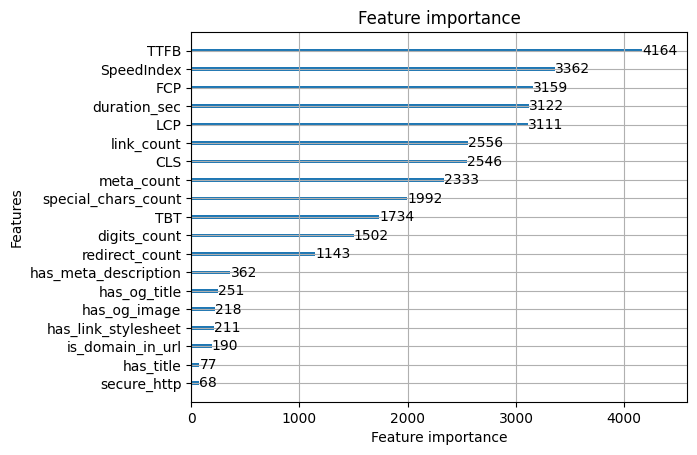

In [43]:
lgb.plot_importance(model, max_num_features=20)

C:\Users\taka2\AppData\Local\Temp\ipykernel_22544\1322111581.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\taka2\.pyenv\pyenv-win\versions\3.10.2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


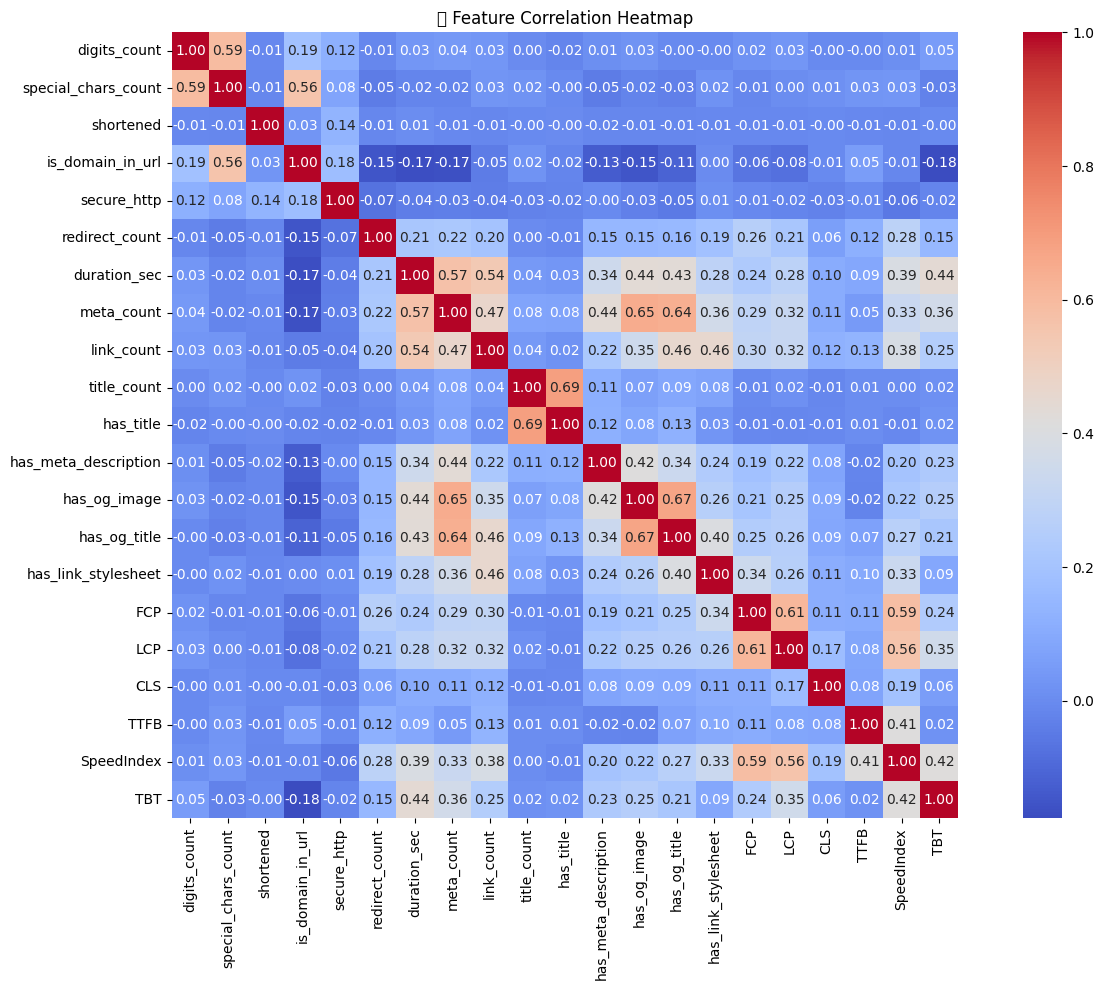

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 숫자형 데이터만 선택
# numeric_df = df.select_dtypes(include=['number'])
numeric_df = df.select_dtypes(include=['int64', 'float64', 'bool'])
numeric_df = numeric_df.drop(columns=['url_type', 'url_len', 'letters_count','performance_score'])

# 상관관계 계산
corr = numeric_df.corr()

# 히트맵 그리기
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("📊 Feature Correlation Heatmap")
plt.tight_layout()
plt.show()
